In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression

root = Path("unified")

all_datasets = {}

for csv_file in root.rglob("all_metrics_combined*.csv"):
    experiment_name = csv_file.parent.name 
    df = pd.read_csv(csv_file)
    df["source"] = experiment_name.upper()  
    all_datasets[experiment_name] = df
    print(f"Loaded cutomers {experiment_name} experiment ({len(df)} rows)")

df_all = pd.concat(all_datasets.values(), ignore_index=True)

print(all_datasets['net_loss'].head())

2025-07-15 13:17:36.590986: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 13:17:36.603398: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-15 13:17:36.680188: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-15 13:17:36.754122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752578256.821653 3131840 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752578256.83

Loaded cutomers net_loss experiment (485 rows)
Loaded cutomers mem_stress experiment (486 rows)
Loaded cutomers IO pressure experiment (481 rows)
Loaded cutomers baseline experiment (492 rows)
Loaded cutomers cpu_stress experiment (484 rows)
   minutes  IO_blocklatency_disk sda IO_blocklatency_source  \
0     0.00                      12.0               NET_LOSS   
1     0.25                      12.0               NET_LOSS   
2     0.50                      13.0               NET_LOSS   
3     0.75                      13.0               NET_LOSS   
4     1.00                      13.0               NET_LOSS   

   IO_blocklatency_Minutes  IO_readbytes_openeuler-home  \
0                     0.00                          0.0   
1                     0.25                          0.0   
2                     0.50                       4096.0   
3                     0.75                       4096.0   
4                     1.00                       4096.0   

   IO_readbytes_openeule

## adding failure feature

In [2]:
def add_failure_feature(df, time_col='minutes'):
    df = df.copy()
    df['Failure'] = 0
    df.loc[(df[time_col] >= 30) & (df[time_col] < 80), 'Failure'] = 1
    return df

def add_failure_to_all_datasets(all_datasets):
    updated_datasets = {}
    
    for name, df in all_datasets.items():
        df_copy = df.copy()
        
        if name.lower() == 'baseline':
            df_copy['Failure'] = 0
        else:
            df_copy['Failure'] = 0
            df_copy.loc[(df_copy['minutes'] >= 30) & (df_copy['minutes'] < 80), 'Failure'] = 1
        
        updated_datasets[name] = df_copy
    
    return updated_datasets


all_datasets = add_failure_to_all_datasets(all_datasets)

# NaN visual

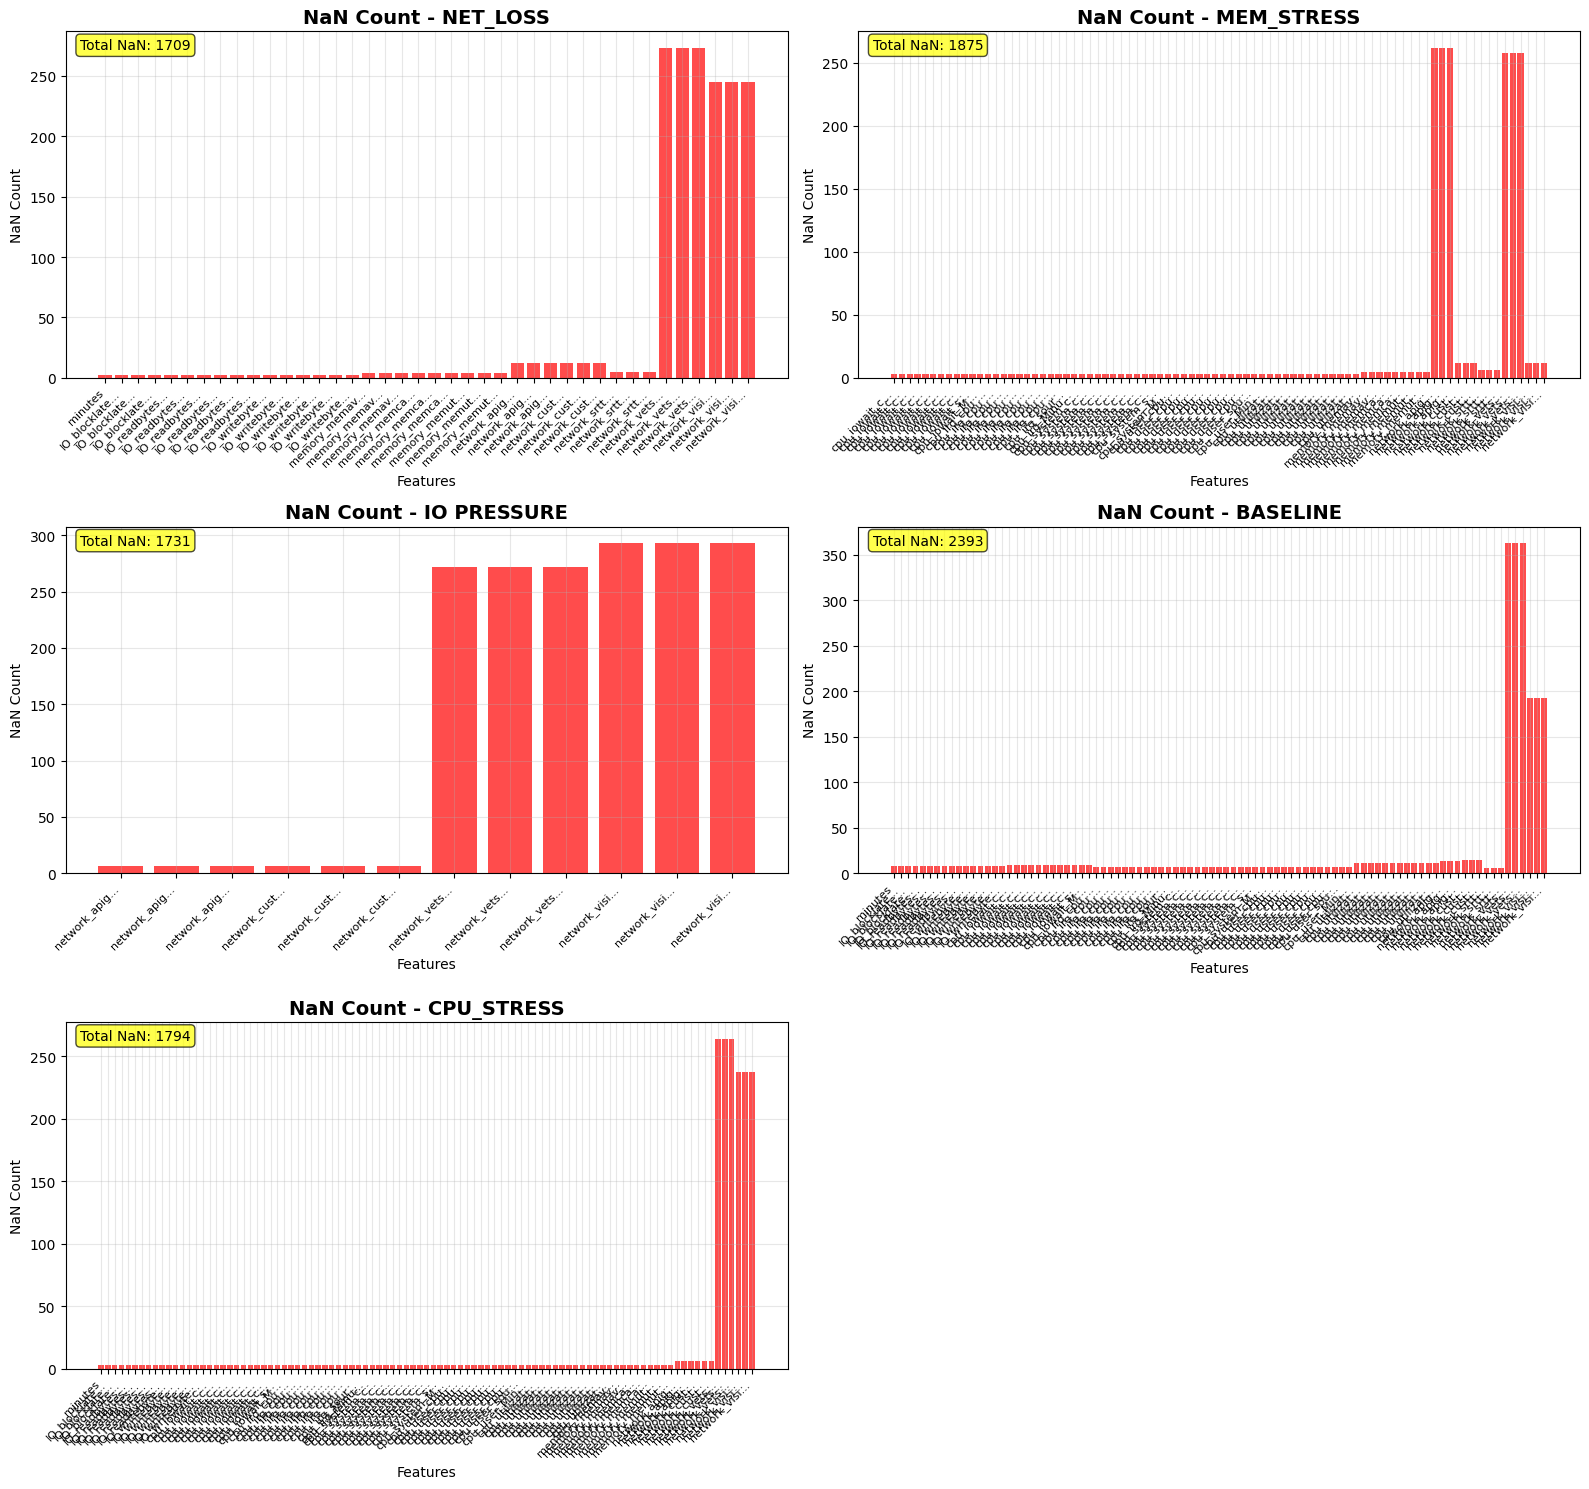


SUMMARY NaN PER ESPERIMENTO
NET_LOSS       :   1709 NaN totali,  40 features con NaN
MEM_STRESS     :   1875 NaN totali,  84 features con NaN
IO PRESSURE    :   1731 NaN totali,  12 features con NaN
BASELINE       :   2393 NaN totali,  91 features con NaN
CPU_STRESS     :   1794 NaN totali,  97 features con NaN


In [3]:
def plot_simple_nan_histogram(df, title="NaN Count Histogram"):

    nan_counts = df.isnull().sum()
    
    has_nan = nan_counts[nan_counts > 0]
    
    if len(has_nan) == 0:
        print("Nessun valore NaN trovato nel dataset")
        return
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(has_nan)), has_nan.values, color='red', alpha=0.7)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('NaN Count', fontsize=12)
    plt.xticks(range(len(has_nan)), has_nan.index, rotation=45, ha='right')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Stampa anche un summary
    print(f"Totale features con NaN: {len(has_nan)}")
    print(f"Totale NaN nel dataset: {has_nan.sum()}")

def plot_nan_distribution_histogram(df, title="NaN Distribution per Row"):
    """
    Plotta la distribuzione del numero di NaN per riga
    """
    # Calcola quanti NaN ci sono per ogni riga
    nan_per_row = df.isnull().sum(axis=1)
    
    plt.figure(figsize=(10, 6))
    
    # Istogramma vero e proprio
    plt.hist(nan_per_row, bins=30, color='purple', alpha=0.7, edgecolor='black')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Numero di NaN per riga', fontsize=12)
    plt.ylabel('Frequenza', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"Statistiche NaN per riga:")
    print(f"Media: {nan_per_row.mean():.2f}")
    print(f"Mediana: {nan_per_row.median():.2f}")
    print(f"Massimo: {nan_per_row.max()}")
    print(f"Righe senza NaN: {(nan_per_row == 0).sum()}")

def plot_nan_histogram_all_experiments(all_datasets):
    """
    Plotta l'istogramma dei NaN per tutti gli esperimenti
    """
    experiments = list(all_datasets.keys())
    n_experiments = len(experiments)
    
    # Calcola dimensioni griglia
    if n_experiments <= 4:
        rows, cols = 2, 2
        figsize = (16, 10)
    else:
        rows = int(np.ceil(n_experiments / 2))
        cols = 2
        figsize = (16, 5*rows)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Se c'è solo un subplot, converti in lista
    if n_experiments == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, exp_name in enumerate(experiments):
        if i < len(axes):
            ax = axes[i]
            df = all_datasets[exp_name]
            
            # Calcola NaN count
            nan_counts = df.isnull().sum()
            has_nan = nan_counts[nan_counts > 0]
            
            if len(has_nan) > 0:
                # Plot bar chart
                bars = ax.bar(range(len(has_nan)), has_nan.values, color='red', alpha=0.7)
                
                ax.set_title(f'NaN Count - {exp_name.upper()}', fontsize=14, fontweight='bold')
                ax.set_xlabel('Features', fontsize=10)
                ax.set_ylabel('NaN Count', fontsize=10)
                
                # Abbrevia i nomi delle features per leggibilità
                feature_names = []
                for name in has_nan.index:
                    if len(name) > 12:
                        # Prendi prime 12 caratteri
                        short_name = name[:12] + "..."
                    else:
                        short_name = name
                    feature_names.append(short_name)
                
                ax.set_xticks(range(len(has_nan)))
                ax.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=8)
                
                ax.grid(True, alpha=0.3)
                
                # Aggiungi valori sopra le barre se sono poche
                if len(has_nan) <= 8:
                    for bar, value in zip(bars, has_nan.values):
                        ax.text(bar.get_x() + bar.get_width()/2, 
                               bar.get_height() + max(has_nan.values)*0.01,
                               f'{int(value)}', ha='center', va='bottom', fontsize=8)
                
                # Summary testuale nell'angolo
                total_nan = has_nan.sum()
                ax.text(0.02, 0.98, f'Total NaN: {total_nan}', transform=ax.transAxes, 
                       fontsize=10, verticalalignment='top', 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
            else:
                # Nessun NaN trovato
                ax.text(0.5, 0.5, f'No NaN\nin {exp_name.upper()}', 
                       ha='center', va='center', transform=ax.transAxes, 
                       fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
                ax.set_title(f'NaN Count - {exp_name.upper()}', fontsize=14, fontweight='bold')
    
    # Nascondi subplot vuoti
    for j in range(len(experiments), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Summary generale
    print(f"\n{'='*60}")
    print("SUMMARY NaN PER ESPERIMENTO")
    print(f"{'='*60}")
    for exp_name, df in all_datasets.items():
        nan_counts = df.isnull().sum()
        has_nan = nan_counts[nan_counts > 0]
        total_nan = has_nan.sum() if len(has_nan) > 0 else 0
        features_with_nan = len(has_nan)
        
        print(f"{exp_name.upper():<15}: {total_nan:>6} NaN totali, {features_with_nan:>3} features con NaN")

# Esempi di utilizzo:

# Tutti gli esperimenti in una dashboard
plot_nan_histogram_all_experiments(all_datasets)


## plots per metric group

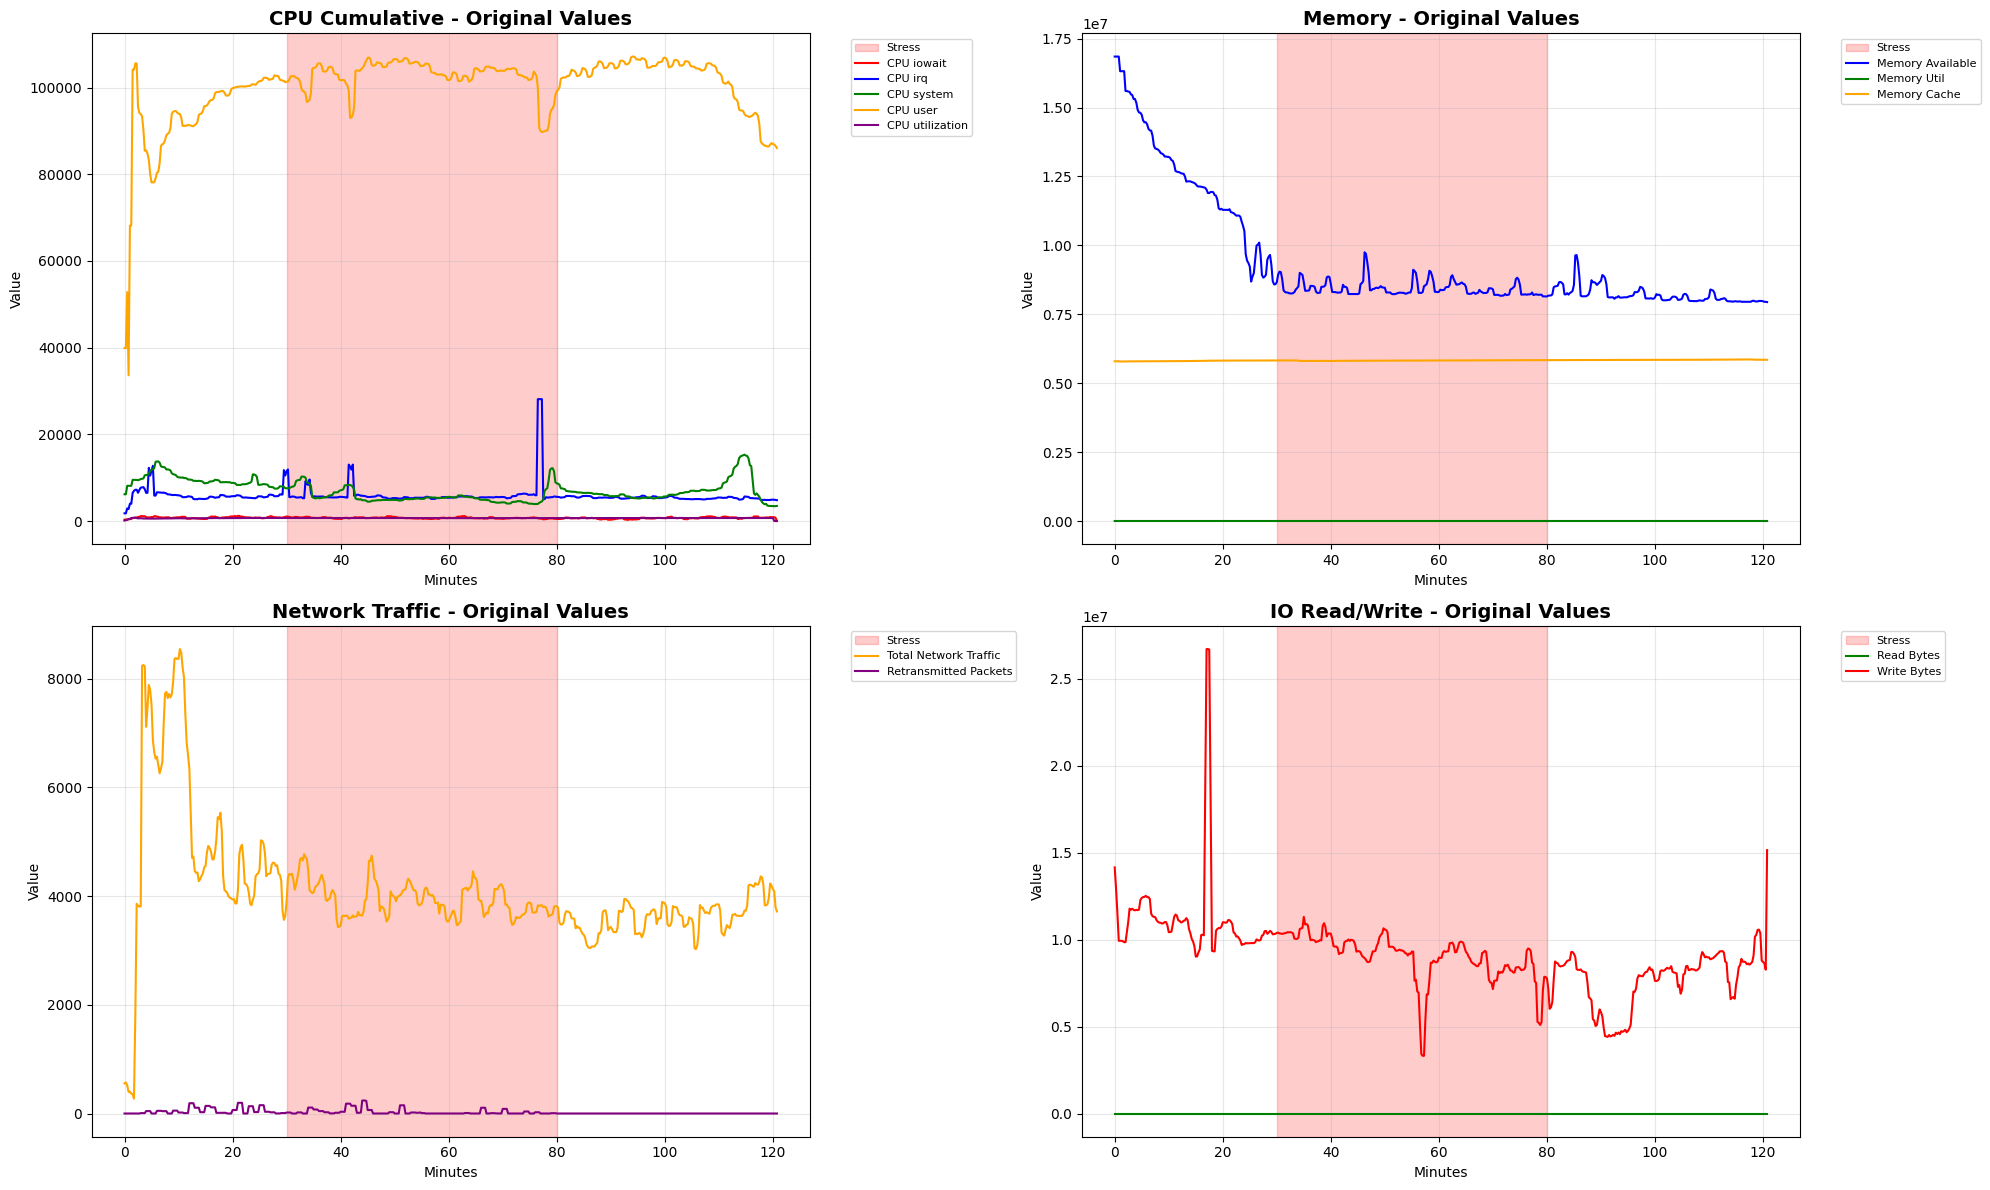

In [4]:
def normalize_0_100(series: pd.Series) -> pd.Series:
    min_val = series.min()
    max_val = series.max()
    if pd.isna(min_val) or pd.isna(max_val) or min_val == max_val:
        return pd.Series([0] * len(series), index=series.index)
    return (series - min_val) / (max_val - min_val) * 100

def process_series_for_plot(series: pd.Series, normalize: bool = True):
    if normalize:
        return normalize_0_100(series)
    else:
        return series

def calculate_cpu_cumulative(df: pd.DataFrame, metric_type: str):
    cpu_cols = [col for col in df.columns if metric_type.lower() in col.lower() 
                and 'cpu' in col.lower() and 'minutes' not in col.lower()]
    
    if not cpu_cols:
        return None
    
    # Filter only numeric columns
    numeric_cols = []
    for col in cpu_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            numeric_cols.append(col)
    
    if not numeric_cols:
        return None
    
    return df[numeric_cols].sum(axis=1)

def calculate_tcp_non_srtt_cumulative(df: pd.DataFrame):
    tcp_cols = []
    for col in df.columns:
        col_lower = col.lower()
        if any(tcp_term in col_lower for tcp_term in ['api', 'service', 'gateway', 'customer', 'vet', 'visit']) and 'srtt' not in col_lower and 'minutes' not in col_lower:
            tcp_cols.append(col)
    
    if not tcp_cols:
        return None
    
    # Filter only numeric columns
    numeric_cols = []
    for col in tcp_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            numeric_cols.append(col)
    
    if not numeric_cols:
        return None
    
    return df[numeric_cols].sum(axis=1)

def calculate_total_network_traffic(df: pd.DataFrame):
    srtt_cols = [col for col in df.columns if 'srtt' in col.lower() 
                 and 'minutes' not in col.lower()]
    
    if not srtt_cols:
        return None
    
    # Filter only numeric columns
    numeric_cols = []
    for col in srtt_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            numeric_cols.append(col)
    
    if not numeric_cols:
        return None
    
    return df[numeric_cols].sum(axis=1)

def safe_sum_numeric_cols(df: pd.DataFrame, cols: list):
    """Safely sum only numeric columns"""
    if not cols:
        return None
    
    numeric_cols = []
    for col in cols:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            numeric_cols.append(col)
    
    if not numeric_cols:
        return None
    
    return df[numeric_cols].sum(axis=1)

def plot_dashboard(df: pd.DataFrame, time_col='minutes', normalize=True):
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    title_suffix = "Normalized (0-100)" if normalize else "Original Values"
    ylabel = "Normalized Value (0-100)" if normalize else "Value"
    
    # CPU Plot
    ax1 = axes[0, 0]
    ax1.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    cpu_metrics = ['iowait', 'irq', 'system', 'user', 'utilization']
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for i, metric in enumerate(cpu_metrics):
        cumulative = calculate_cpu_cumulative(df, metric)
        if cumulative is not None:
            processed_series = process_series_for_plot(cumulative, normalize)
            ax1.plot(df[time_col], processed_series, 
                    label=f'CPU {metric}', 
                    linewidth=1.5,
                    color=colors[i % len(colors)])
    
    ax1.set_title(f"CPU Cumulative - {title_suffix}", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Minutes", fontsize=10)
    ax1.set_ylabel(ylabel, fontsize=10)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    if normalize:
        ax1.set_ylim(0, 100)
    
    # Memory Plot
    ax2 = axes[0, 1]
    ax2.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    mem_available = [col for col in df.columns if 'memavailable' in col.lower() 
                     and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    mem_util = [col for col in df.columns if 'memutil' in col.lower() 
                and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    mem_cache = [col for col in df.columns if 'memcache' in col.lower() 
                 and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    
    colors = ['blue', 'green', 'orange']
    labels = ['Memory Available', 'Memory Util', 'Memory Cache']
    metric_groups = [mem_available, mem_util, mem_cache]
    
    for i, (metrics, label, color) in enumerate(zip(metric_groups, labels, colors)):
        for col in metrics:
            if col in df.columns:
                processed_series = process_series_for_plot(df[col], normalize)
                ax2.plot(df[time_col], processed_series, 
                        label=label, 
                        linewidth=1.5,
                        color=color)
                break
    
    ax2.set_title(f"Memory - {title_suffix}", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Minutes", fontsize=10)
    ax2.set_ylabel(ylabel, fontsize=10)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)
    if normalize:
        ax2.set_ylim(0, 100)
    
    # Network Plot
    ax3 = axes[1, 0]
    ax3.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    total_network_traffic = calculate_total_network_traffic(df)
    retransmitted_packets = calculate_tcp_non_srtt_cumulative(df)
    
    if total_network_traffic is not None:
        processed_traffic = process_series_for_plot(total_network_traffic, normalize)
        ax3.plot(df[time_col], processed_traffic, 
                label='Total Network Traffic', 
                linewidth=1.5,
                color='orange')
    
    if retransmitted_packets is not None:
        processed_packets = process_series_for_plot(retransmitted_packets, normalize)
        ax3.plot(df[time_col], processed_packets, 
                label='Retransmitted Packets', 
                linewidth=1.5,
                color='purple')
    
    ax3.set_title(f"Network Traffic - {title_suffix}", fontsize=14, fontweight='bold')
    ax3.set_xlabel("Minutes", fontsize=10)
    ax3.set_ylabel(ylabel, fontsize=10)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)
    if normalize:
        ax3.set_ylim(0, 100)
    
    # IO Plot
    ax4 = axes[1, 1]
    ax4.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    read_cols = [col for col in df.columns if 'readbytes' in col.lower() 
                 and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    write_cols = [col for col in df.columns if 'writebytes' in col.lower() 
                  and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    
    read_cumulative = safe_sum_numeric_cols(df, read_cols)
    write_cumulative = safe_sum_numeric_cols(df, write_cols)
    
    if read_cumulative is not None:
        processed_read = process_series_for_plot(read_cumulative, normalize)
        ax4.plot(df[time_col], processed_read, 
                label='Read Bytes', 
                linewidth=1.5,
                color='green')
    
    if write_cumulative is not None:
        processed_write = process_series_for_plot(write_cumulative, normalize)
        ax4.plot(df[time_col], processed_write, 
                label='Write Bytes', 
                linewidth=1.5,
                color='red')
    
    ax4.set_title(f"IO Read/Write - {title_suffix}", fontsize=14, fontweight='bold')
    ax4.set_xlabel("Minutes", fontsize=10)
    ax4.set_ylabel(ylabel, fontsize=10)
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)
    if normalize:
        ax4.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()

# Dashboard con valori originali  
plot_dashboard(all_datasets['baseline'], normalize=False)



## clean NaN and redundant features

In [5]:
def clean_dataset(df):
    df = df.copy()
    
    cpu_8_9_cols = [col for col in df.columns if 'cpu_8' in col or 'cpu_9' in col or 'cpu 8' in col or 'cpu 9' in col]
    if cpu_8_9_cols:
        df = df.drop(columns=cpu_8_9_cols)
    
    tcp_cols = [col for col in df.columns if any(term in col.lower() for term in ['api', 'service', 'gateway', 'customer', 'vet', 'visit']) and 'srtt' not in col.lower()]
    for col in tcp_cols:
        df[col] = df[col].fillna(0)
    
    other_cols = [col for col in df.columns if col not in tcp_cols and df[col].isnull().sum() > 0]
    for col in other_cols:
        df[col] = df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    
    return df

def clean_all_datasets(all_datasets):
    processed = {}
    for name, df in all_datasets.items():
        original_shape = df.shape
        processed_df = clean_dataset(df)
        processed[name] = processed_df
        
        dropped_cols = original_shape[1] - processed_df.shape[1]
        nan_count = processed_df.isnull().sum().sum()
        print(f"  {name}: {original_shape} → {processed_df.shape} | Dropped: {dropped_cols} | NaN: {nan_count}")
    
    return processed



def clean_minutes_columns(df, keep_col='minutes'):
 
    df = df.copy()
    
    minutes_cols = [col for col in df.columns if 'minutes' in col.lower()]
    
    print(f"Found {len(minutes_cols)} columns with 'minutes': {minutes_cols}")
    
    if keep_col in minutes_cols:
        to_keep = keep_col
    elif minutes_cols:
        to_keep = minutes_cols[0]  
        print(f"'{keep_col}' not found, keeping '{to_keep}' instead")
    else:
        return df
    
    to_drop = [col for col in minutes_cols if col != to_keep]
    
    if to_drop:
        df = df.drop(columns=to_drop)
    
    return df

def clean_all_datasets_minutes(all_datasets):

    cleaned_datasets = {}

    for name, df in all_datasets.items():
        cleaned_df = clean_minutes_columns(df)
        cleaned_datasets[name] = cleaned_df
    
    return cleaned_datasets

all_datasets = clean_all_datasets_minutes(all_datasets)
all_datasets = clean_all_datasets(all_datasets)

Found 17 columns with 'minutes': ['minutes', 'IO_blocklatency_Minutes', 'IO_readbytes_Minutes', 'IO_writebytes_Minutes', 'cpu_iowait_Minutes', 'cpu_irq_Minutes', 'cpu_system_Minutes', 'cpu_user_Minutes', 'cpu_utilization_Minutes', 'memory_memavailable_Minutes', 'memory_memcache_Minutes', 'memory_memutil_Minutes', 'network_apigateway_Minutes', 'network_customersservice_Minutes', 'network_srtt_Minutes', 'network_vetsservice_Minutes', 'network_visitsservice_Minutes']
Found 17 columns with 'minutes': ['minutes', 'IO_blocklatency_Minutes', 'IO_readbytes_Minutes', 'IO_writebytes_Minutes', 'cpu_iowait_Minutes', 'cpu_irq_Minutes', 'cpu_system_Minutes', 'cpu_user_Minutes', 'cpu_utilization_Minutes', 'memory_memavailable_Minutes', 'memory_memcache_Minutes', 'memory_memutil_Minutes', 'network_apigateway_Minutes', 'network_customersservice_Minutes', 'network_srtt_Minutes', 'network_vetsservice_Minutes', 'network_visitsservice_Minutes']
Found 17 columns with 'minutes': ['minutes', 'IO_blocklatency_

/tmp/ipykernel_3131840/4088997993.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_3131840/4088997993.py:14: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_3131840/4088997993.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_3131840/4088997993.py:14: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_o

## re-plot

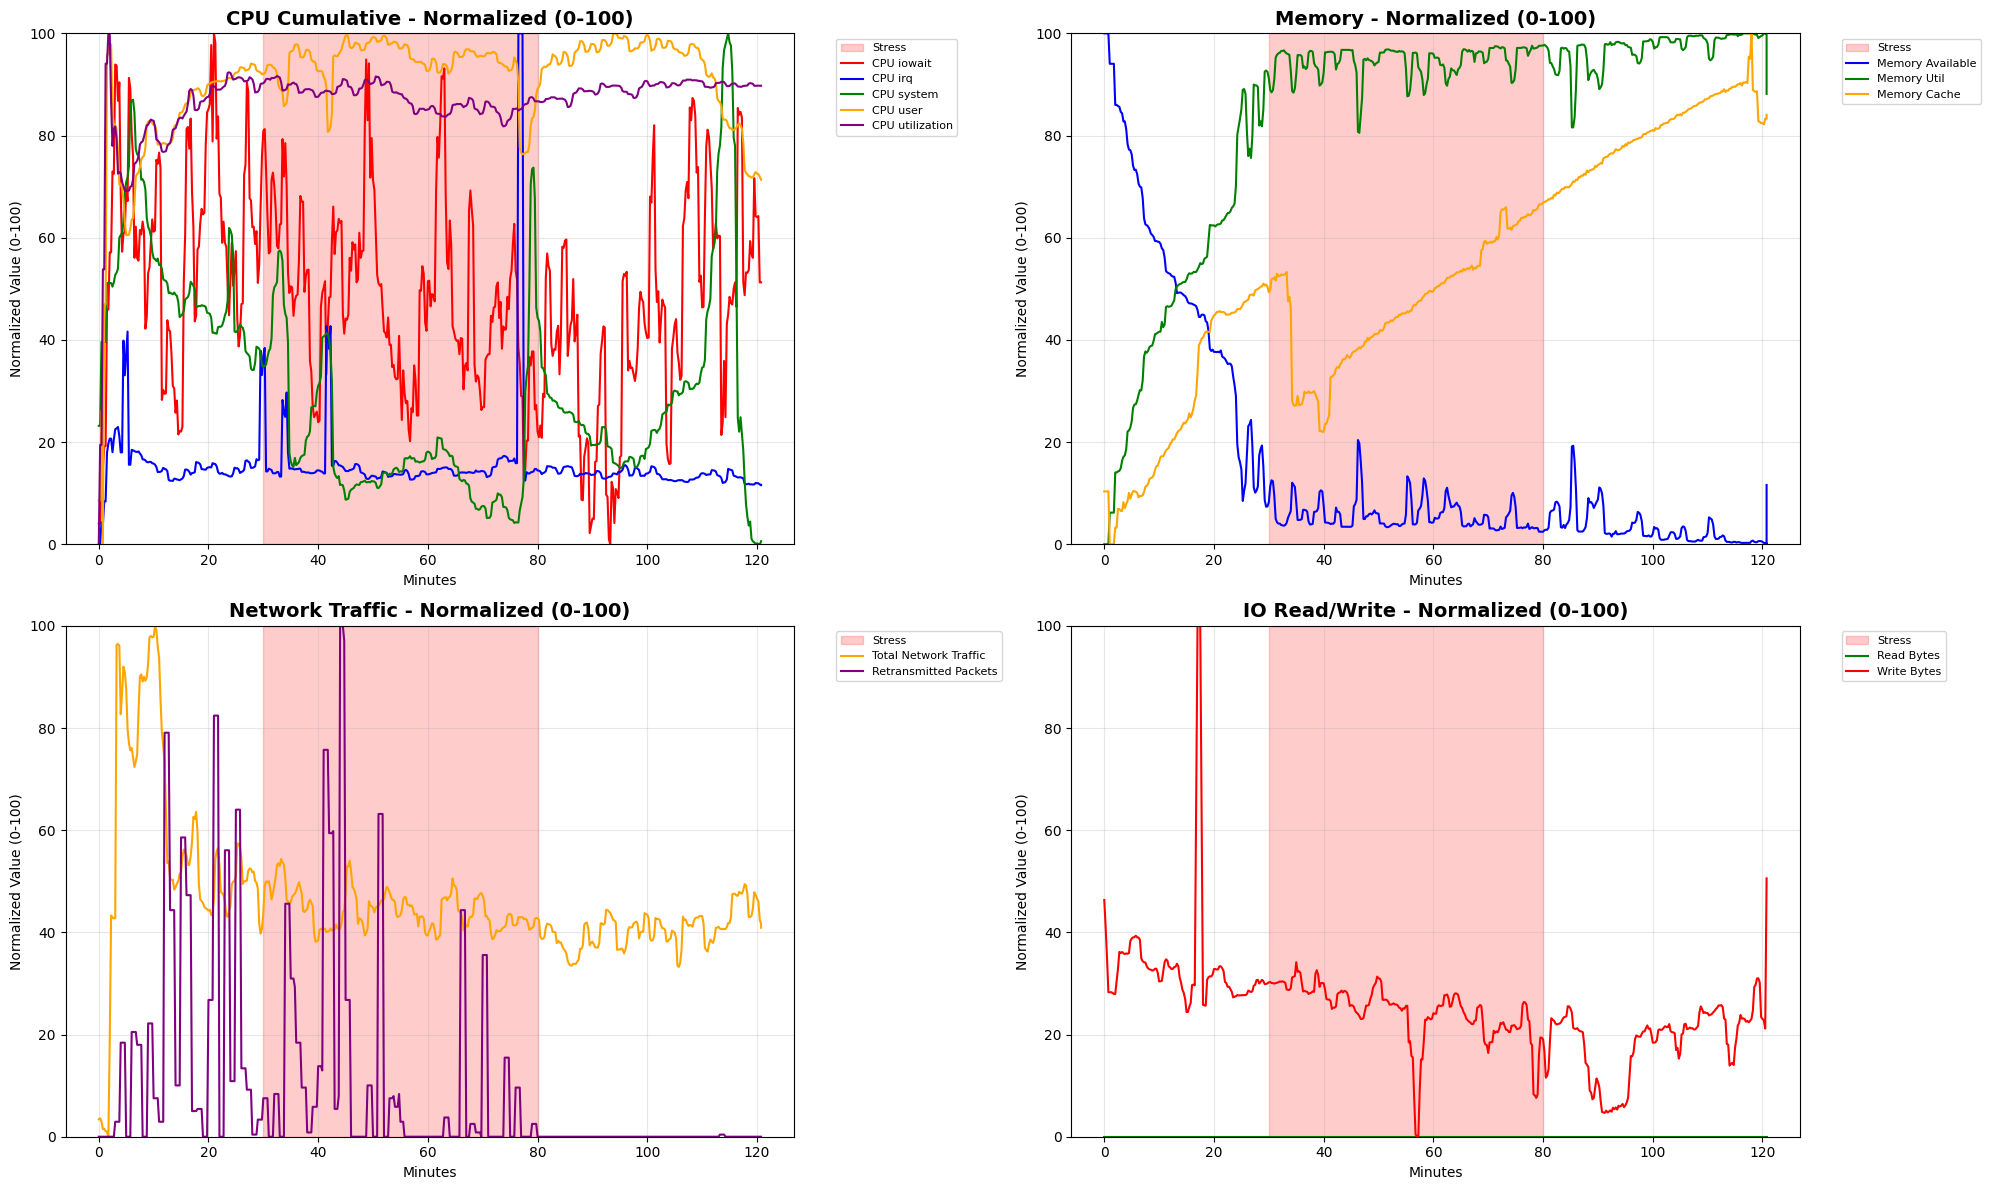

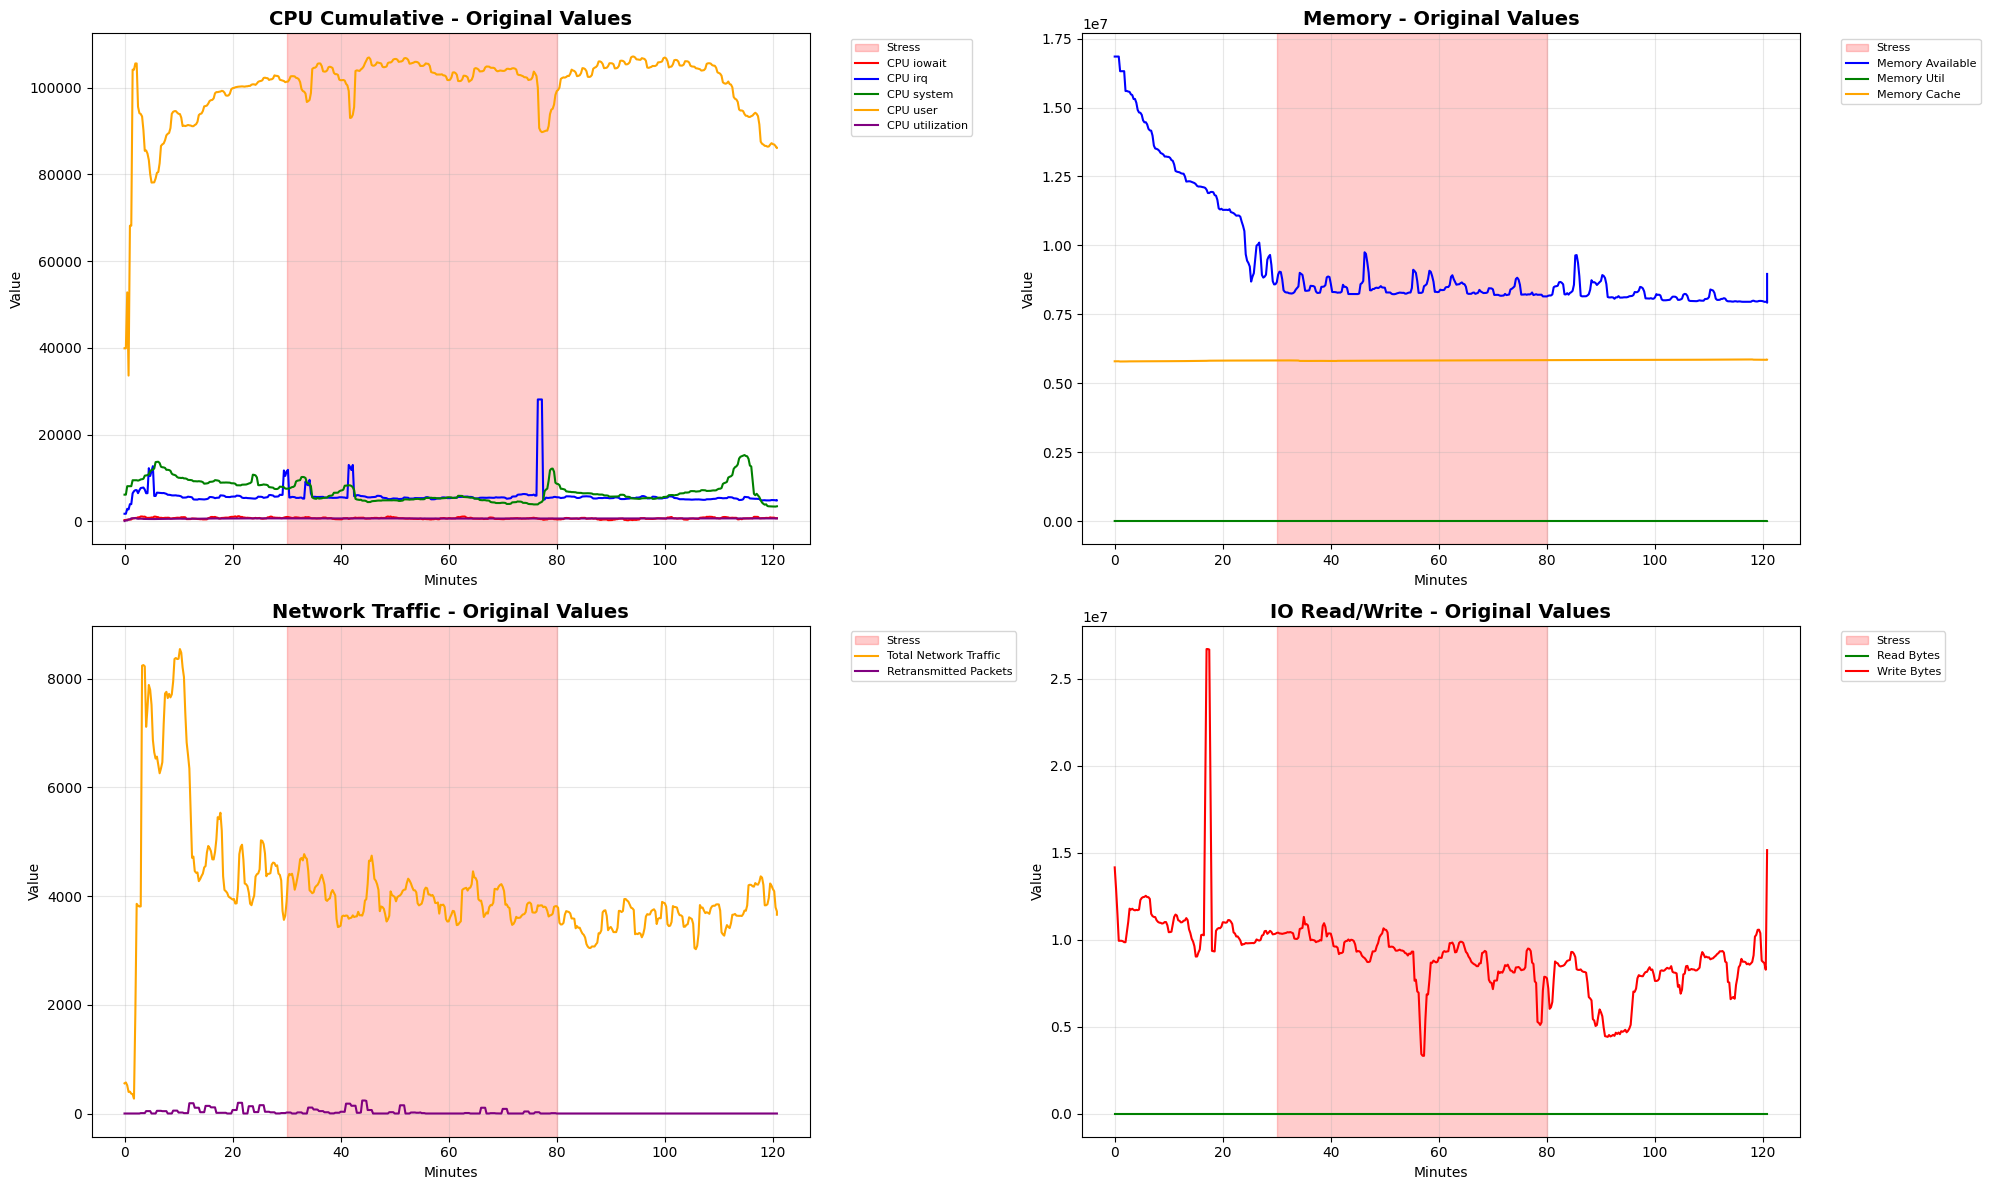

In [6]:
def normalize_0_100(series: pd.Series) -> pd.Series:
    min_val = series.min()
    max_val = series.max()
    if pd.isna(min_val) or pd.isna(max_val) or min_val == max_val:
        return pd.Series([0] * len(series), index=series.index)
    return (series - min_val) / (max_val - min_val) * 100

def process_series_for_plot(series: pd.Series, normalize: bool = True):
    if normalize:
        return normalize_0_100(series)
    else:
        return series

def safe_sum_columns(df: pd.DataFrame, columns: list):
    if not columns:
        return None
    
    numeric_cols = []
    for col in columns:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            numeric_cols.append(col)
    
    if not numeric_cols:
        return None
    
    return df[numeric_cols].sum(axis=1)

def calculate_cpu_cumulative(df: pd.DataFrame, metric_type: str):
    cpu_cols = [col for col in df.columns if metric_type.lower() in col.lower() 
                and 'cpu' in col.lower() and 'minutes' not in col.lower()]
    
    return safe_sum_columns(df, cpu_cols)

def calculate_tcp_non_srtt_cumulative(df: pd.DataFrame):
    tcp_cols = []
    for col in df.columns:
        col_lower = col.lower()
        if any(tcp_term in col_lower for tcp_term in ['api', 'service', 'gateway', 'customer', 'vet', 'visit']) and 'srtt' not in col_lower and 'minutes' not in col_lower:
            tcp_cols.append(col)
    
    return safe_sum_columns(df, tcp_cols)

def calculate_total_network_traffic(df: pd.DataFrame):
    srtt_cols = [col for col in df.columns if 'srtt' in col.lower() 
                 and 'minutes' not in col.lower()]
    
    return safe_sum_columns(df, srtt_cols)

def plot_dashboard(df: pd.DataFrame, time_col='minutes', normalize=True):
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    title_suffix = "Normalized (0-100)" if normalize else "Original Values"
    ylabel = "Normalized Value (0-100)" if normalize else "Value"
    
    # CPU Plot
    ax1 = axes[0, 0]
    ax1.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    cpu_metrics = ['iowait', 'irq', 'system', 'user', 'utilization']
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for i, metric in enumerate(cpu_metrics):
        cumulative = calculate_cpu_cumulative(df, metric)
        if cumulative is not None:
            processed_series = process_series_for_plot(cumulative, normalize)
            ax1.plot(df[time_col], processed_series, 
                    label=f'CPU {metric}', 
                    linewidth=1.5,
                    color=colors[i % len(colors)])
    
    ax1.set_title(f"CPU Cumulative - {title_suffix}", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Minutes", fontsize=10)
    ax1.set_ylabel(ylabel, fontsize=10)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    if normalize:
        ax1.set_ylim(0, 100)
    
    # Memory Plot
    ax2 = axes[0, 1]
    ax2.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    mem_available = [col for col in df.columns if 'memavailable' in col.lower() 
                     and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    mem_util = [col for col in df.columns if 'memutil' in col.lower() 
                and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    mem_cache = [col for col in df.columns if 'memcache' in col.lower() 
                 and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    
    colors = ['blue', 'green', 'orange']
    labels = ['Memory Available', 'Memory Util', 'Memory Cache']
    metric_groups = [mem_available, mem_util, mem_cache]
    
    for i, (metrics, label, color) in enumerate(zip(metric_groups, labels, colors)):
        for col in metrics:
            if col in df.columns:
                processed_series = process_series_for_plot(df[col], normalize)
                ax2.plot(df[time_col], processed_series, 
                        label=label, 
                        linewidth=1.5,
                        color=color)
                break
    
    ax2.set_title(f"Memory - {title_suffix}", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Minutes", fontsize=10)
    ax2.set_ylabel(ylabel, fontsize=10)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)
    if normalize:
        ax2.set_ylim(0, 100)
    
    # Network Plot
    ax3 = axes[1, 0]
    ax3.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    total_network_traffic = calculate_total_network_traffic(df)
    retransmitted_packets = calculate_tcp_non_srtt_cumulative(df)
    
    if total_network_traffic is not None:
        processed_traffic = process_series_for_plot(total_network_traffic, normalize)
        ax3.plot(df[time_col], processed_traffic, 
                label='Total Network Traffic', 
                linewidth=1.5,
                color='orange')
    
    if retransmitted_packets is not None:
        processed_packets = process_series_for_plot(retransmitted_packets, normalize)
        ax3.plot(df[time_col], processed_packets, 
                label='Retransmitted Packets', 
                linewidth=1.5,
                color='purple')
    
    ax3.set_title(f"Network Traffic - {title_suffix}", fontsize=14, fontweight='bold')
    ax3.set_xlabel("Minutes", fontsize=10)
    ax3.set_ylabel(ylabel, fontsize=10)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)
    if normalize:
        ax3.set_ylim(0, 100)
    
    # IO Plot
    ax4 = axes[1, 1]
    ax4.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    read_cols = [col for col in df.columns if 'readbytes' in col.lower() 
                 and 'minutes' not in col.lower()]
    write_cols = [col for col in df.columns if 'writebytes' in col.lower() 
                  and 'minutes' not in col.lower()]
    
    read_cumulative = safe_sum_columns(df, read_cols)
    write_cumulative = safe_sum_columns(df, write_cols)
    
    if read_cumulative is not None:
        processed_read = process_series_for_plot(read_cumulative, normalize)
        ax4.plot(df[time_col], processed_read, 
                label='Read Bytes', 
                linewidth=1.5,
                color='green')
    
    if write_cumulative is not None:
        processed_write = process_series_for_plot(write_cumulative, normalize)
        ax4.plot(df[time_col], processed_write, 
                label='Write Bytes', 
                linewidth=1.5,
                color='red')
    
    ax4.set_title(f"IO Read/Write - {title_suffix}", fontsize=14, fontweight='bold')
    ax4.set_xlabel("Minutes", fontsize=10)
    ax4.set_ylabel(ylabel, fontsize=10)
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)
    if normalize:
        ax4.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()

def plot_cpu_cumulative_thin(df: pd.DataFrame, time_col='minutes', normalize=True):
    if time_col not in df.columns:
        return
    
    cpu_metrics = ['iowait', 'irq', 'system', 'user', 'utilization']
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    plt.figure(figsize=(14, 8))
    plt.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    for i, metric in enumerate(cpu_metrics):
        cumulative = calculate_cpu_cumulative(df, metric)
        if cumulative is not None:
            processed_series = process_series_for_plot(cumulative, normalize)
            plt.plot(df[time_col], processed_series, 
                    label=f'CPU {metric} (cumulativo)', 
                    linewidth=1.5,
                    color=colors[i % len(colors)])
    
    title_suffix = "Normalizzate (0-100)" if normalize else "Valori Originali"
    ylabel = "Valore normalizzato (0-100)" if normalize else "Valore"
    
    plt.title(f"Metriche CPU Cumulative - {title_suffix}", fontsize=16, fontweight='bold')
    plt.xlabel("Tempo (minuti)", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    if normalize:
        plt.ylim(0, 100)
    
    plt.tight_layout()
    plt.show()

def plot_memory_metrics(df: pd.DataFrame, time_col='minutes', normalize=True):
    if time_col not in df.columns:
        return
    
    mem_available = [col for col in df.columns if 'memavailable' in col.lower() 
                     and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    mem_util = [col for col in df.columns if 'memutil' in col.lower() 
                and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    mem_cache = [col for col in df.columns if 'memcache' in col.lower() 
                 and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    
    plt.figure(figsize=(14, 8))
    plt.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    colors = ['blue', 'green', 'orange']
    labels = ['Memory Available', 'Memory Util', 'Memory Cache']
    metric_groups = [mem_available, mem_util, mem_cache]
    
    for i, (metrics, label, color) in enumerate(zip(metric_groups, labels, colors)):
        for col in metrics:
            if col in df.columns:
                processed_series = process_series_for_plot(df[col], normalize)
                plt.plot(df[time_col], processed_series, 
                        label=label, 
                        linewidth=1.5,
                        color=color)
                break
    
    title_suffix = "Normalizzate (0-100)" if normalize else "Valori Originali"
    ylabel = "Valore normalizzato (0-100)" if normalize else "Valore"
    
    plt.title(f"Metriche Memory - {title_suffix}", fontsize=16, fontweight='bold')
    plt.xlabel("Tempo (minuti)", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    if normalize:
        plt.ylim(0, 100)
    
    plt.tight_layout()
    plt.show()
    
plot_dashboard(all_datasets['baseline'])

plot_dashboard(all_datasets['baseline'], normalize=False)



## heatmap

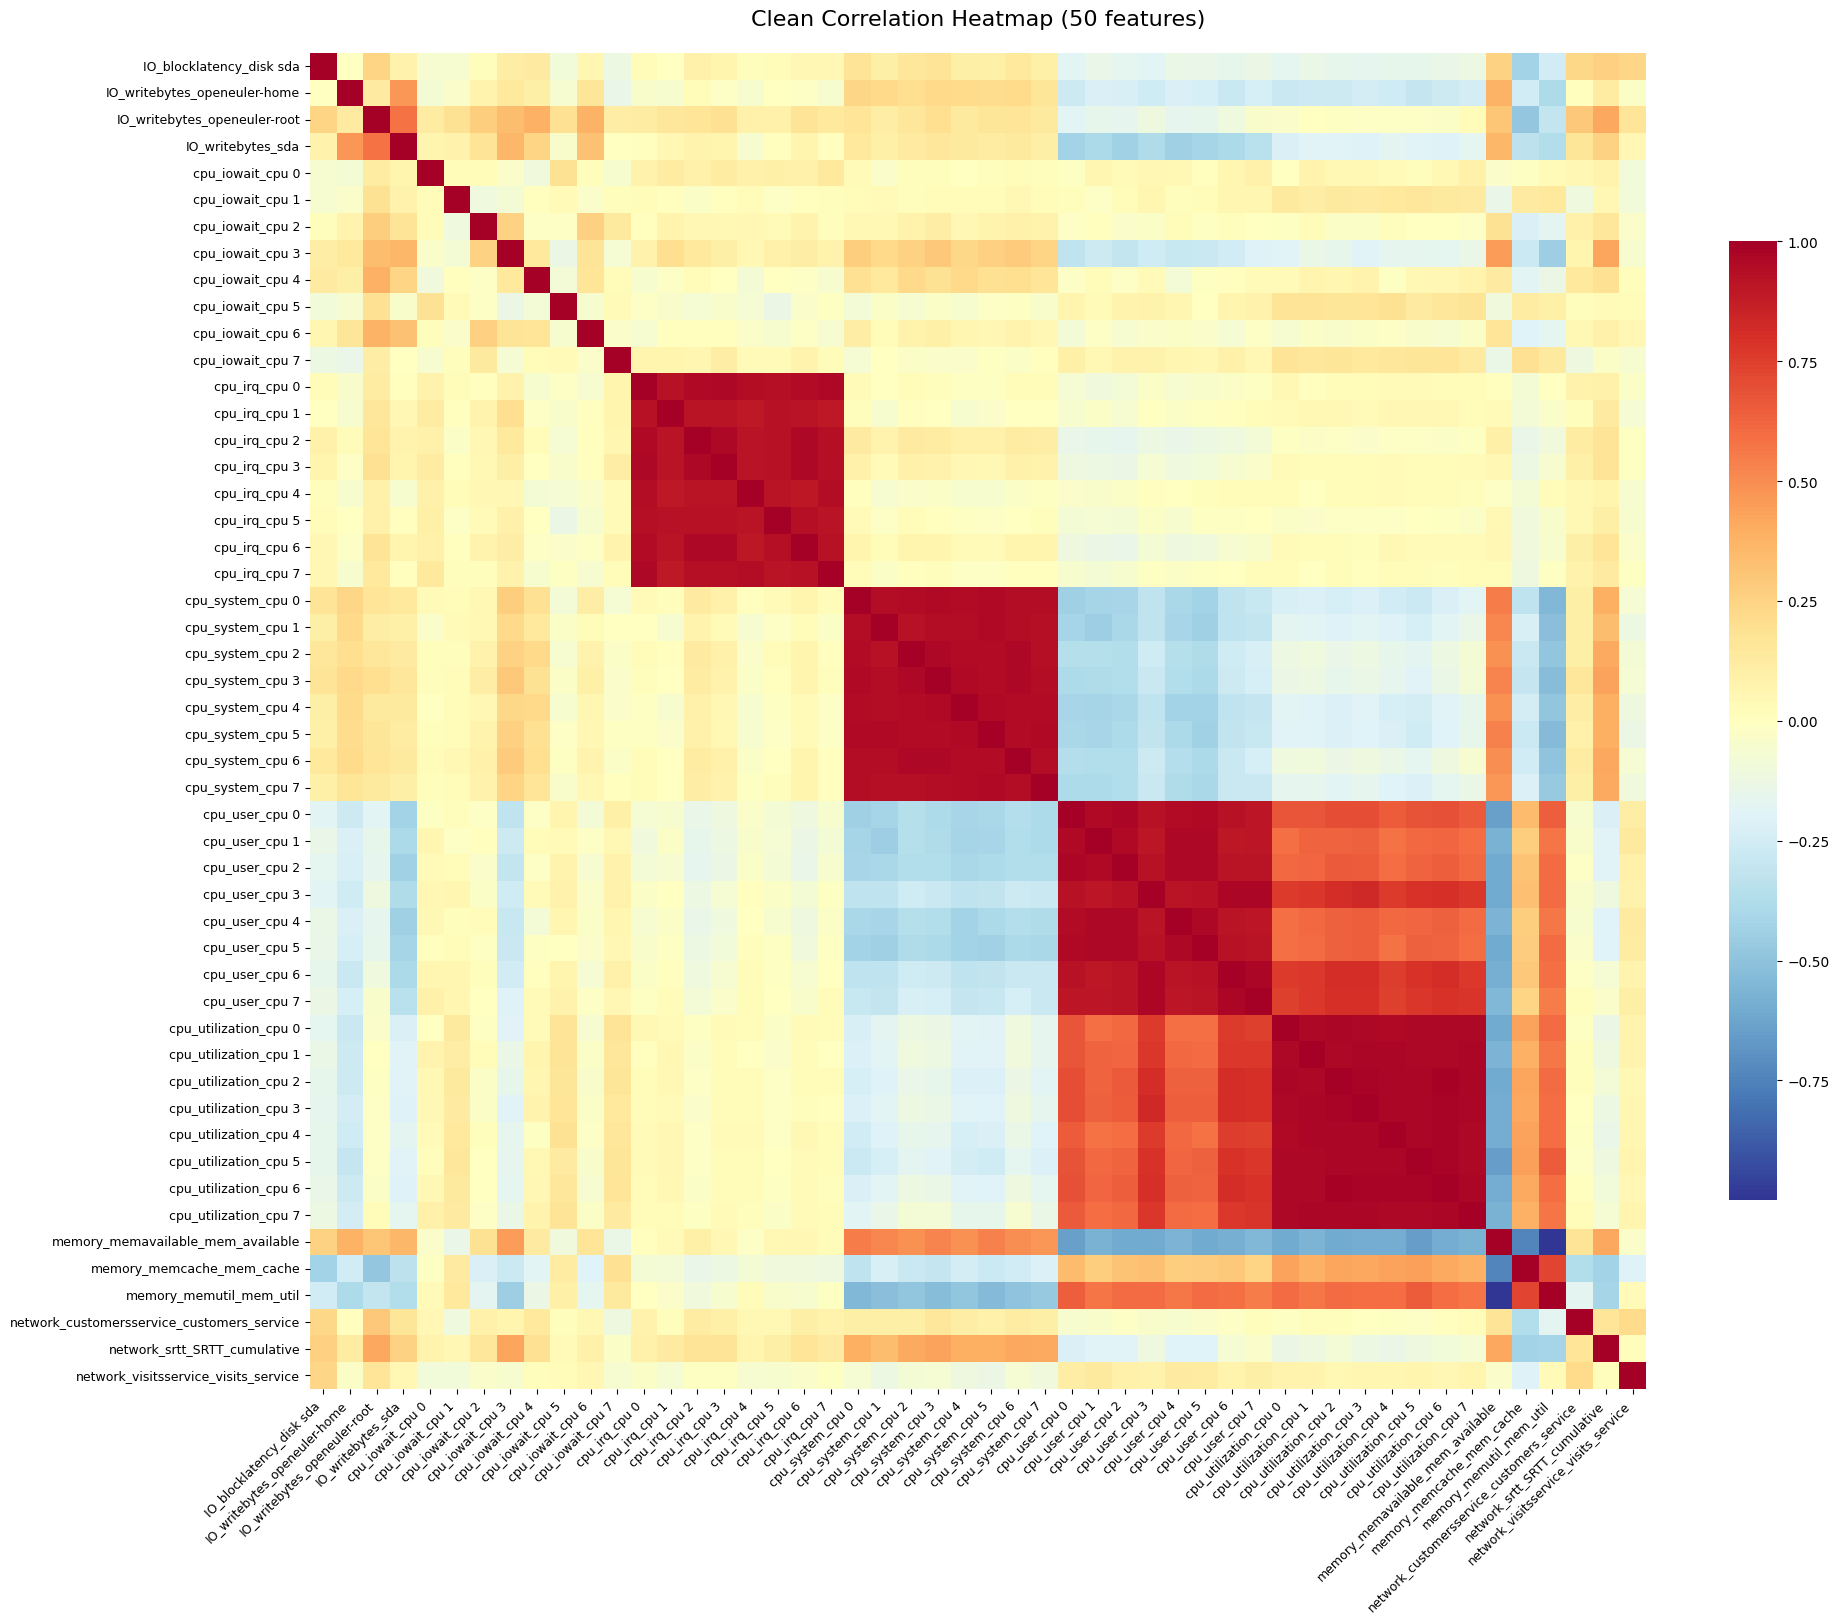

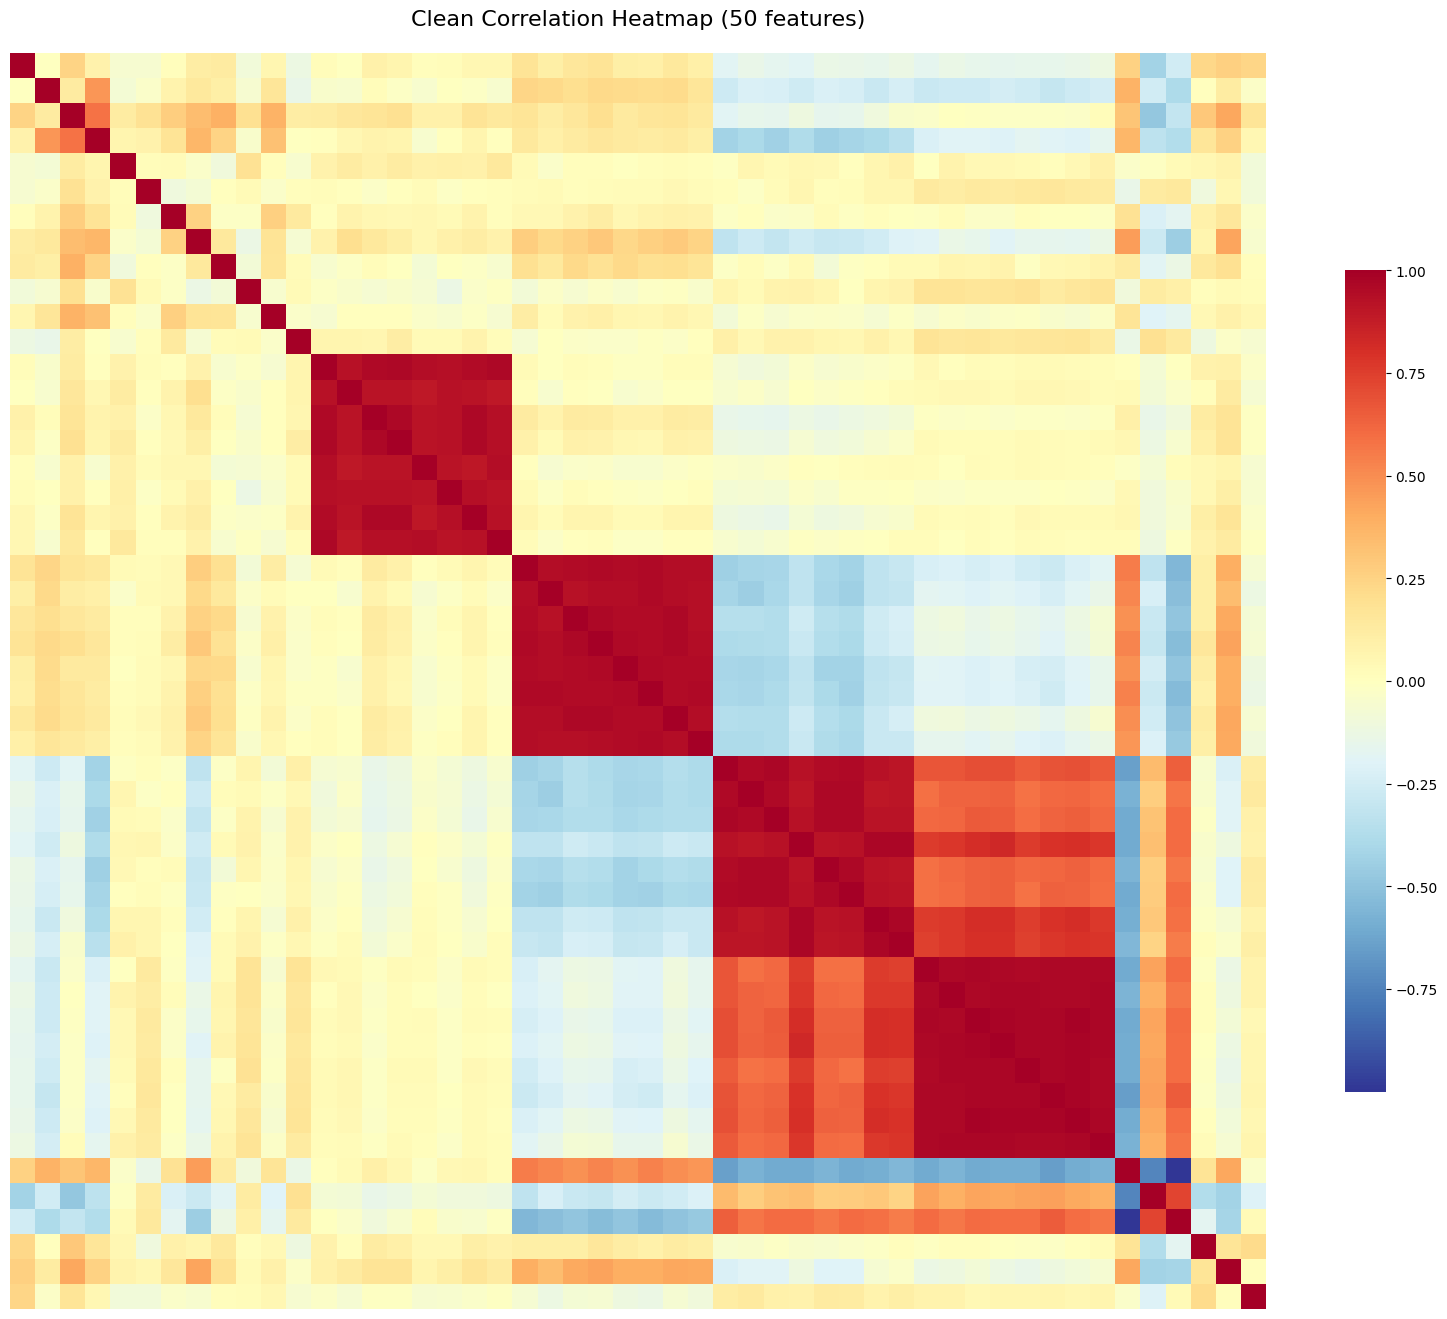

,IO_blocklatency_disk sda,IO_writebytes_openeuler-home,IO_writebytes_openeuler-root,IO_writebytes_sda,cpu_iowait_cpu 0,cpu_iowait_cpu 1,cpu_iowait_cpu 2,cpu_iowait_cpu 3,cpu_iowait_cpu 4,cpu_iowait_cpu 5,...,cpu_utilization_cpu 4,cpu_utilization_cpu 5,cpu_utilization_cpu 6,cpu_utilization_cpu 7,memory_memavailable_mem_available,memory_memcache_mem_cache,memory_memutil_mem_util,network_customersservice_customers_service,network_srtt_SRTT_cumulative,network_visitsservice_visits_service
IO_blocklatency_disk sda,1.000000,-0.001692,0.245196,0.082854,-0.060753,-0.062017,0.009887,0.114088,0.125164,-0.087677,...,-0.153579,-0.148926,-0.143503,-0.119306,0.252957,-0.423258,-0.252394,0.233318,0.261795,0.240650
IO_writebytes_openeuler-home,-0.001692,1.000000,0.127417,0.472206,-0.072644,-0.032341,0.071182,0.147664,0.104861,-0.062089,...,-0.259080,-0.298679,-0.272689,-0.242809,0.382663,-0.250652,-0.385354,0.003761,0.120137,-0.028134
IO_writebytes_openeuler-root,0.245196,0.127417,1.000000,0.578273,0.119722,0.183756,0.270415,0.336595,0.390601,0.188442,...,-0.016636,-0.016267,-0.026126,0.018145,0.310954,-0.477601,-0.309302,0.291205,0.418468,0.166830
IO_writebytes_sda,0.082854,0.472206,0.578273,1.000000,0.063172,0.085322,0.172158,0.362771,0.248151,-0.042192,...,-0.176573,-0.194376,-0.204868,-0.170585,0.366210,-0.332040,-0.367877,0.156706,0.251389,0.049693
cpu_iowait_cpu 0,-0.060753,-0.072644,0.119722,0.063172,1.000000,0.017911,0.025240,-0.034318,-0.097150,0.186747,...,0.037624,0.014374,0.045261,0.086477,-0.032087,-0.008218,0.034471,0.051406,0.073446,-0.088285
cpu_iowait_cpu 1,-0.062017,-0.032341,0.183756,0.085322,0.017911,1.000000,-0.106368,-0.074982,0.003246,0.033453,...,0.141973,0.153839,0.135125,0.131624,-0.145399,0.132816,0.146611,-0.106861,0.048476,-0.088715
cpu_iowait_cpu 2,0.009887,0.071182,0.270415,0.172158,0.025240,-0.106368,1.000000,0.255734,-0.021663,-0.023170,...,0.014365,-0.006127,-0.004584,-0.018654,0.181310,-0.219126,-0.179326,0.092842,0.150445,-0.038931
cpu_iowait_cpu 3,0.114088,0.147664,0.336595,0.362771,-0.034318,-0.074982,0.255734,1.000000,0.143997,-0.131878,...,-0.158691,-0.156821,-0.170457,-0.136722,0.451887,-0.279093,-0.452553,0.062861,0.425436,-0.051866
cpu_iowait_cpu 4,0.125164,0.104861,0.390601,0.248151,-0.097150,0.003246,-0.021663,0.143997,1.000000,-0.081594,...,-0.014561,0.041994,0.051034,0.074653,0.125856,-0.186719,-0.126238,0.140779,0.195281,0.008443
cpu_iowait_cpu 5,-0.087677,-0.062089,0.188442,-0.042192,0.186747,0.033453,-0.023170,-0.131878,-0.081594,1.000000,...,0.181606,0.129439,0.153935,0.175176,-0.096412,0.121393,0.097111,0.009670,0.032802,0.017797


In [7]:
def super_clean_heatmap(data, title="Clean Correlation Heatmap", show_labels=True):
    numeric_data = data.select_dtypes(include=[np.number])
    
    if 'minutes' in numeric_data.columns:
        numeric_data = numeric_data.drop(columns=['minutes'])
    
    cpu_8_9_cols = [col for col in numeric_data.columns if 'cpu_8' in col or 'cpu_9' in col or 'cpu 8' in col or 'cpu 9' in col]
    if cpu_8_9_cols:
        numeric_data = numeric_data.drop(columns=cpu_8_9_cols)
    
    zero_variance_cols = []
    for col in numeric_data.columns:
        if numeric_data[col].var() == 0 or numeric_data[col].sum() == 0:
            zero_variance_cols.append(col)
    
    if zero_variance_cols:
        numeric_data = numeric_data.drop(columns=zero_variance_cols)
    
    nan_threshold = len(numeric_data) * 0.5
    high_nan_cols = [col for col in numeric_data.columns if numeric_data[col].isnull().sum() > nan_threshold]
    
    if high_nan_cols:
        numeric_data = numeric_data.drop(columns=high_nan_cols)
    
    numeric_data = numeric_data.fillna(0)
    corr = numeric_data.corr()
    corr = corr.fillna(0)
    
    if show_labels:
        fig, ax = plt.subplots(figsize=(20, 18))
    else:
        fig, ax = plt.subplots(figsize=(16, 14))
    
    sns.heatmap(corr, 
                cmap='RdYlBu_r', 
                center=0,
                square=True,
                cbar_kws={"shrink": .6},
                xticklabels=show_labels,
                yticklabels=show_labels,
                ax=ax)
    
    ax.set_title(f'{title} ({len(corr)} features)', fontsize=16, pad=20)
    
    if show_labels:
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(rotation=0, fontsize=9)
        plt.subplots_adjust(bottom=0.2, left=0.2)
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    return corr

def labeled_heatmap(data):
    return super_clean_heatmap(data, show_labels=True)

def clean_heatmap(data):
    return super_clean_heatmap(data, show_labels=False)

labeled_heatmap(all_datasets['baseline'])
clean_heatmap(all_datasets['baseline'])

/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


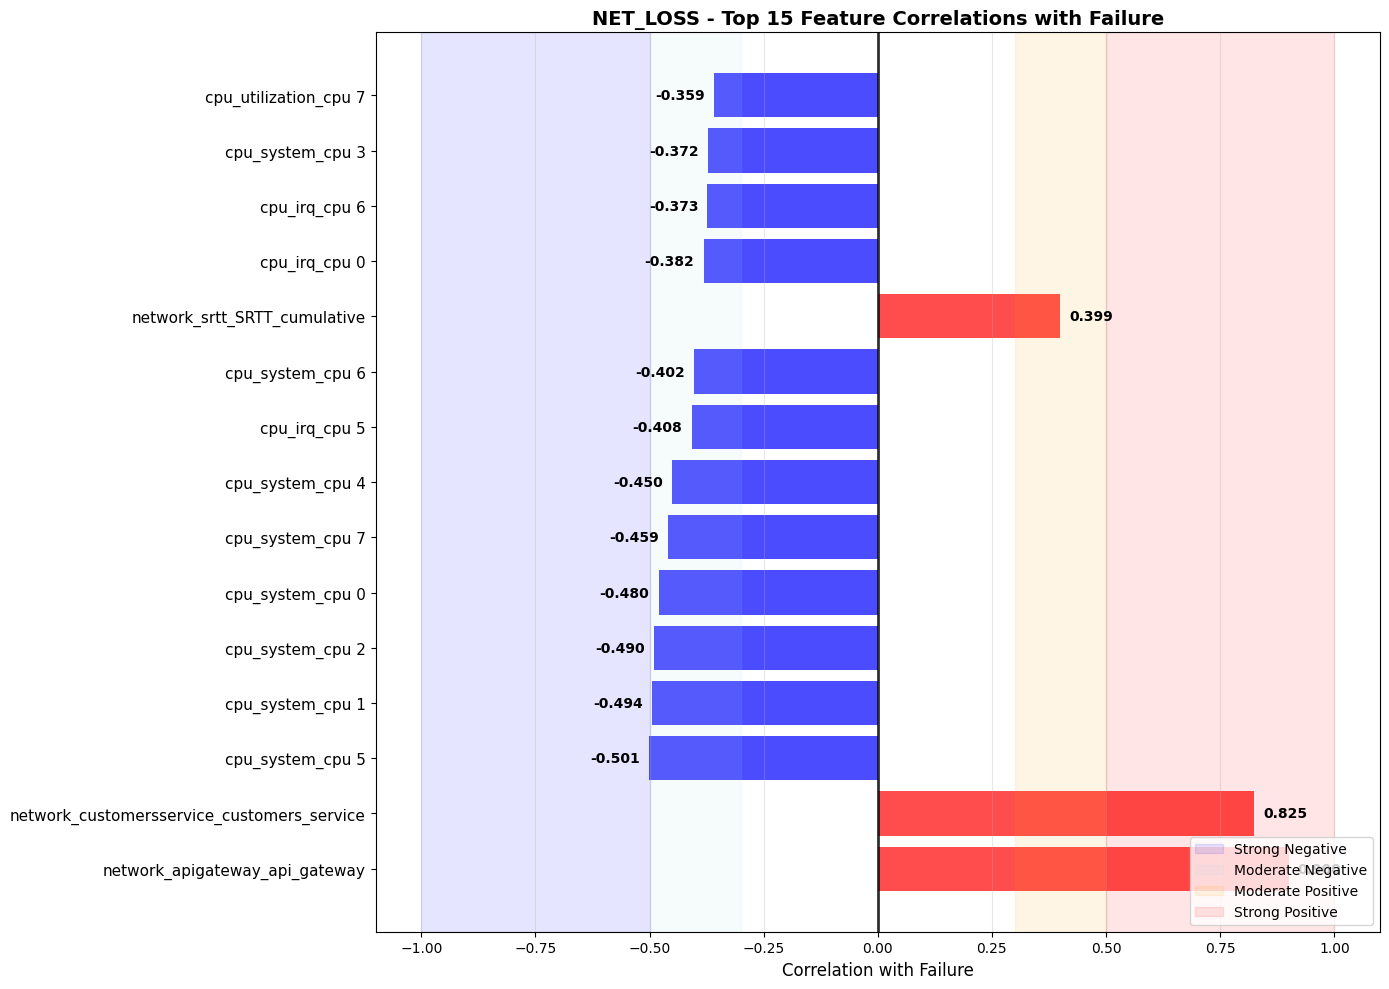

/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


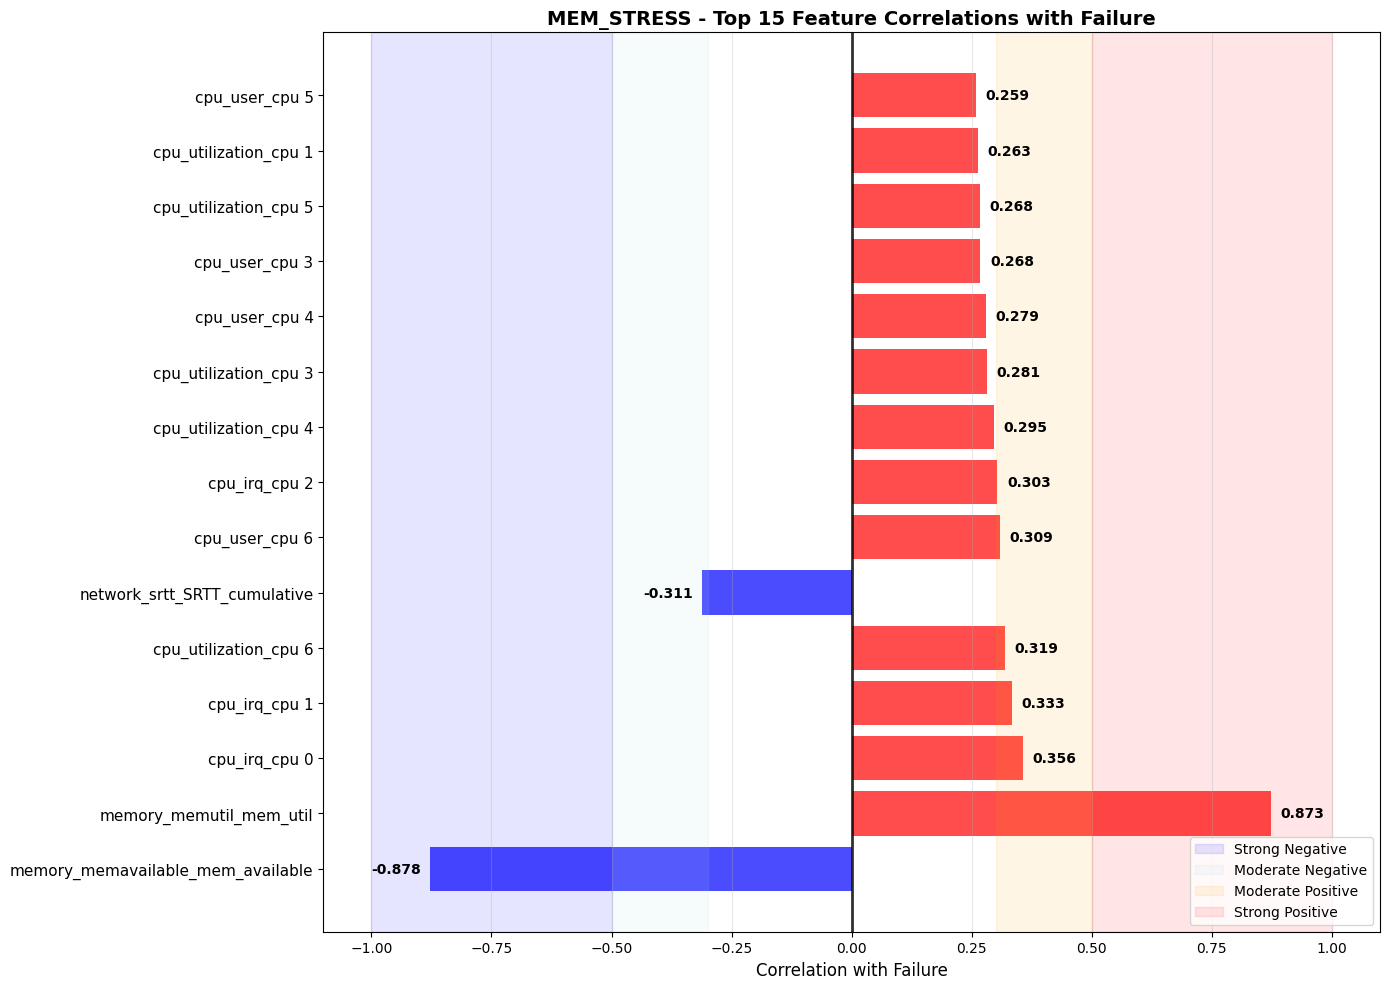

/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


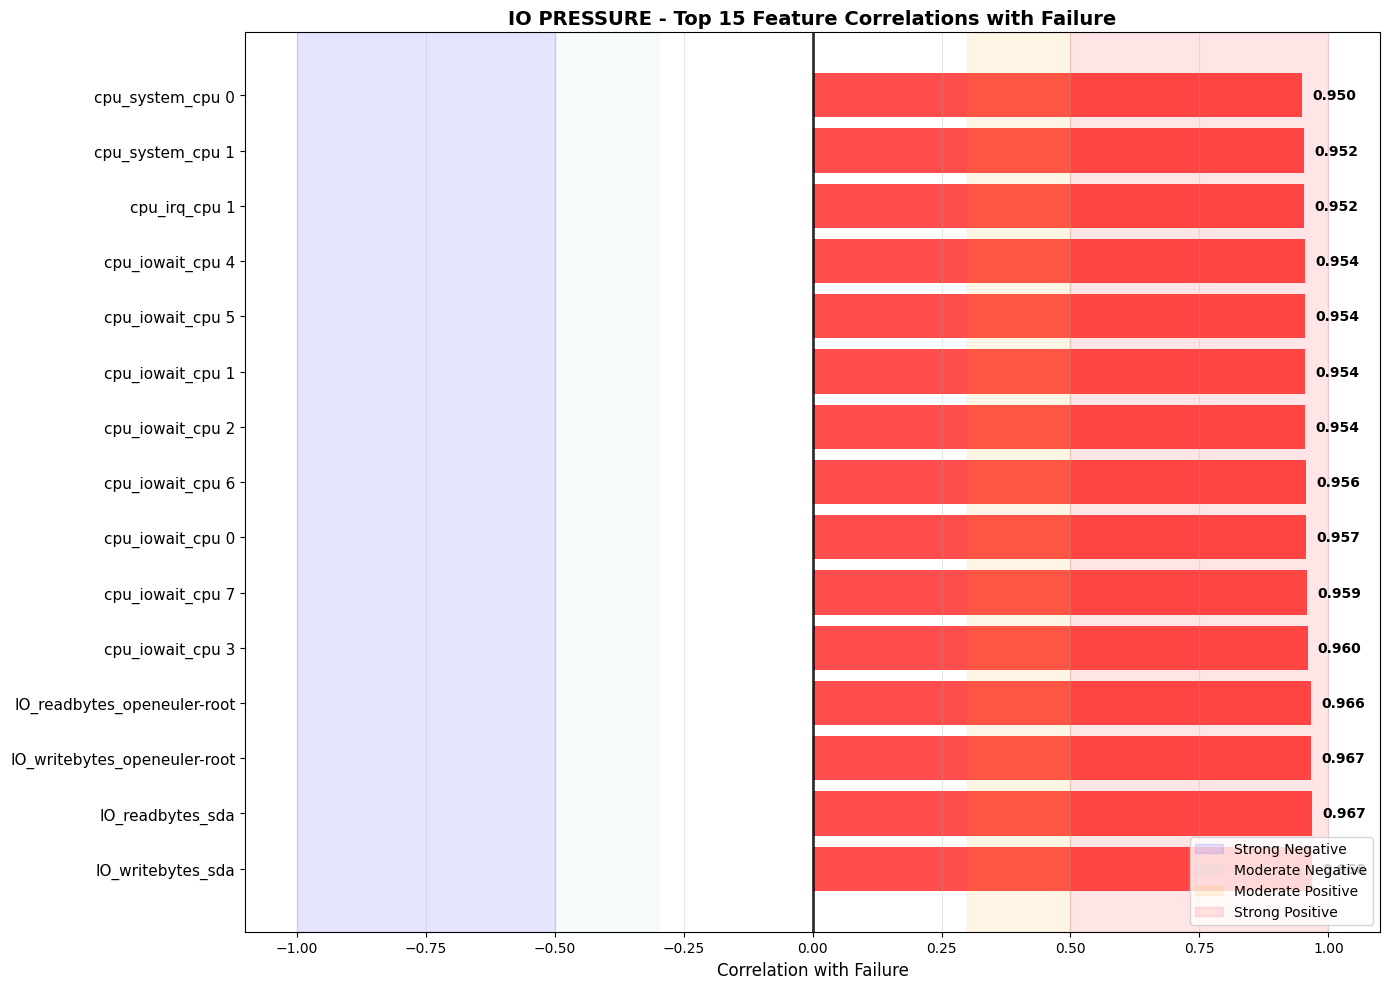

/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


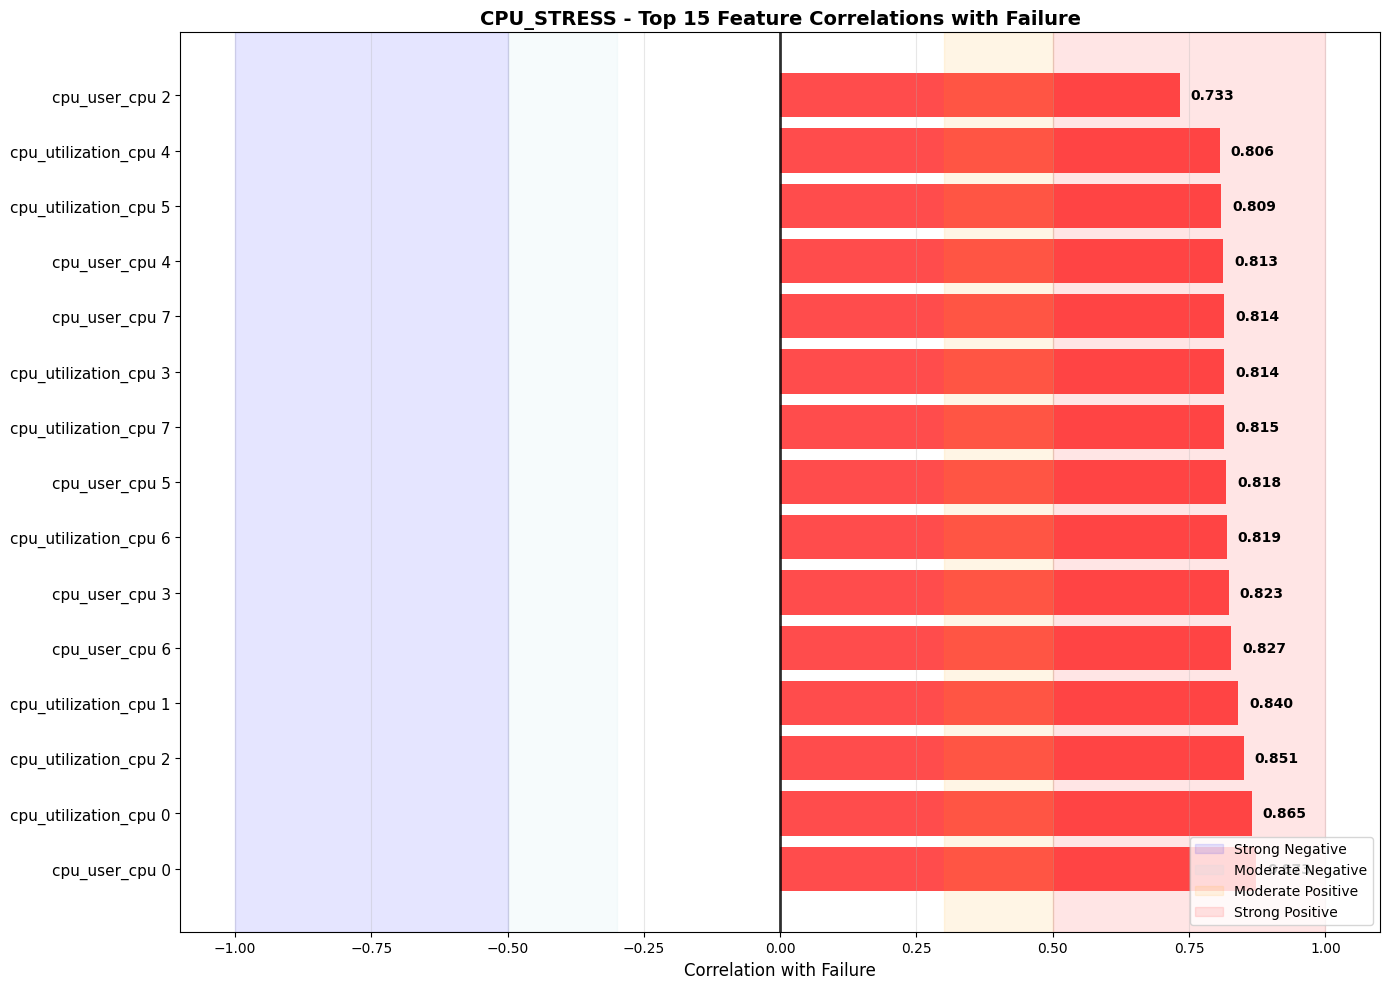

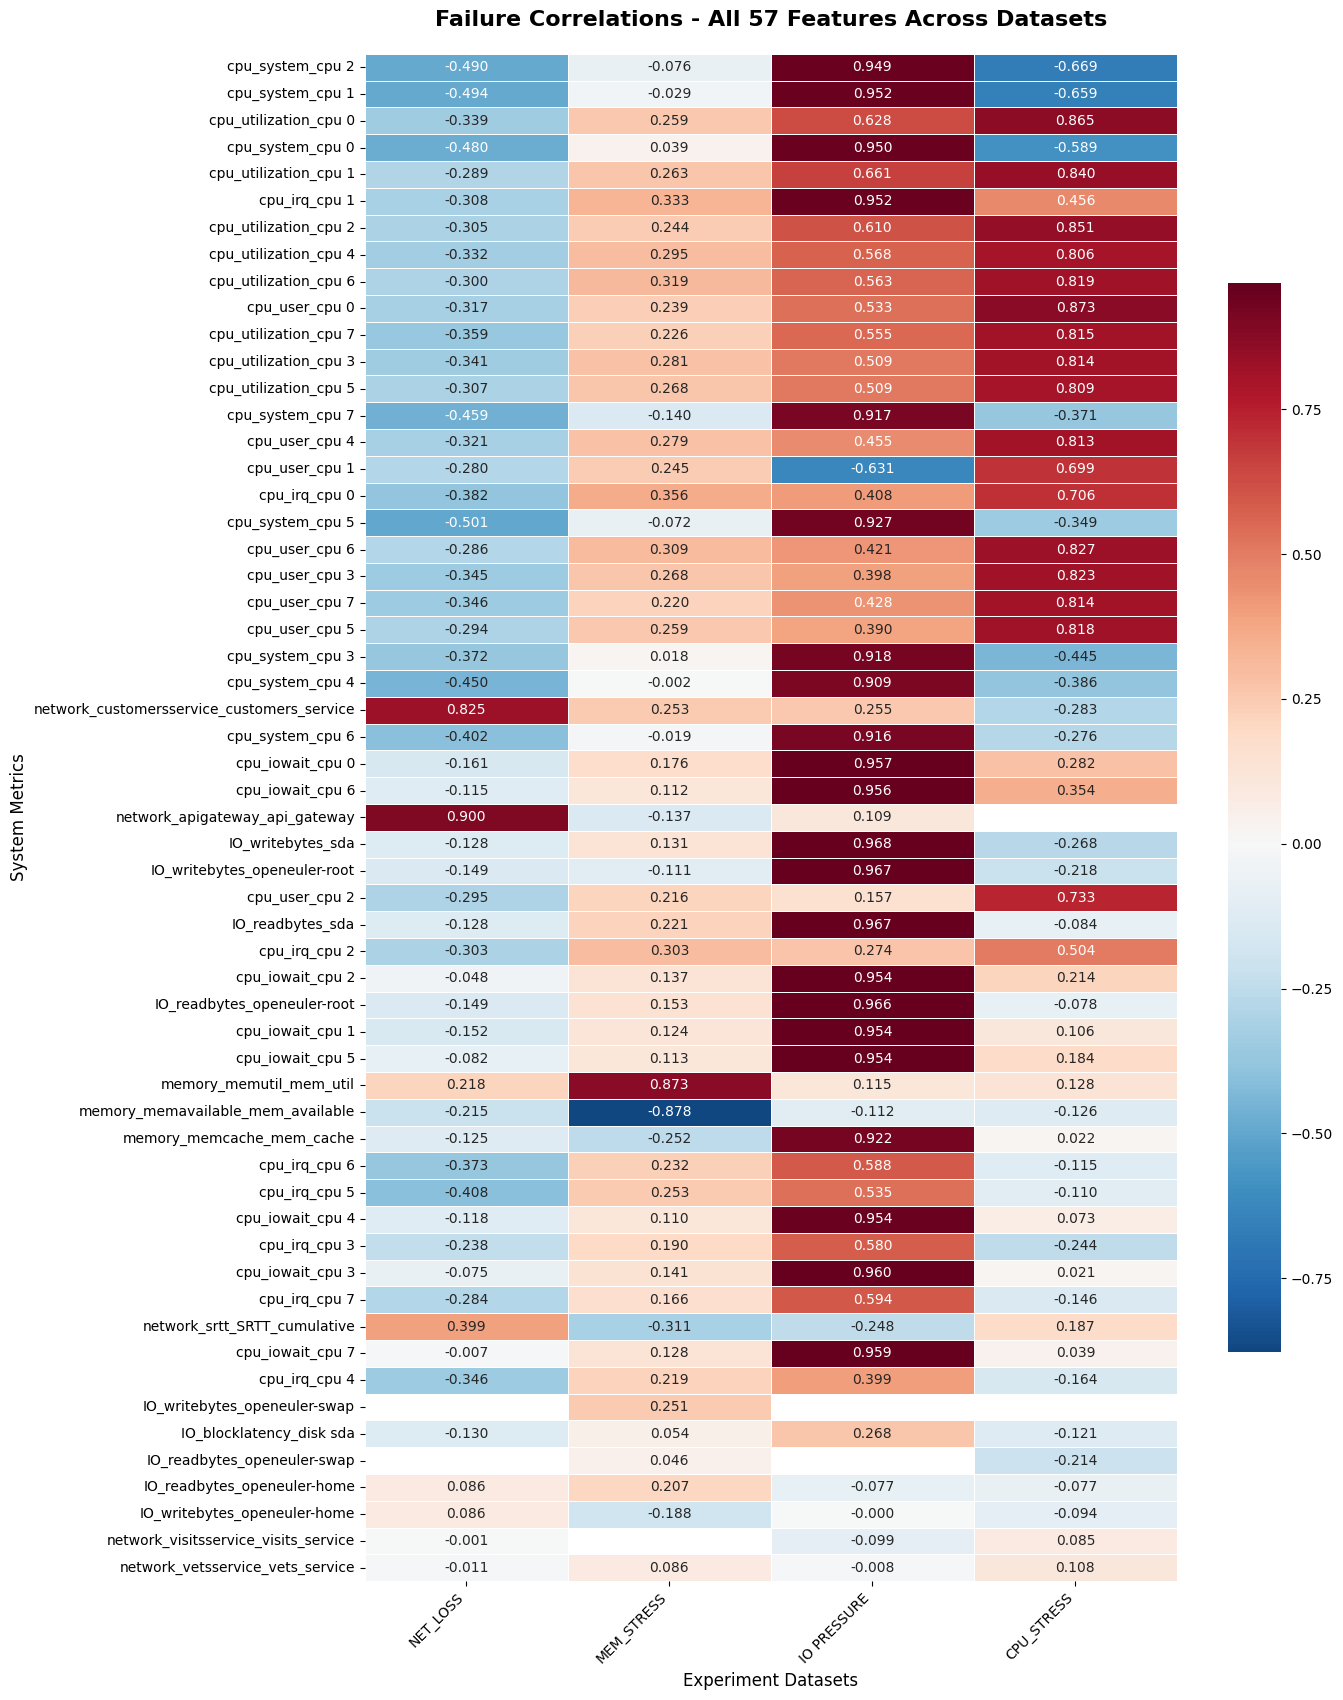

In [8]:
def failure_correlations(df, target_col='Failure'):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols if col not in [target_col, 'minutes']]
    
    correlations = {}
    for col in feature_cols:
        corr = df[col].corr(df[target_col])
        if not pd.isna(corr):
            correlations[col] = corr
    
    corr_df = pd.DataFrame(list(correlations.items()), columns=['feature', 'correlation'])
    corr_df['abs_correlation'] = corr_df['correlation'].abs()
    corr_df = corr_df.sort_values('abs_correlation', ascending=False)
    
    return corr_df

def plot_failure_correlations(df, target_col='Failure', top_n=20, dataset_name="Dataset"):
    corr_df = failure_correlations(df, target_col)
    if corr_df is None:
        return None
    
    top_corr = corr_df.head(top_n)
    
    plt.figure(figsize=(14, 10))
    colors = ['red' if x > 0 else 'blue' for x in top_corr['correlation']]
    bars = plt.barh(range(len(top_corr)), top_corr['correlation'], color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_corr)), top_corr['feature'], fontsize=11)
    plt.xlabel('Correlation with Failure', fontsize=12)
    plt.title(f'{dataset_name.upper()} - Top {top_n} Feature Correlations with Failure', 
              fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    for i, (bar, corr) in enumerate(zip(bars, top_corr['correlation'])):
        plt.text(corr + (0.02 if corr > 0 else -0.02), i, f'{corr:.3f}', 
                va='center', ha='left' if corr > 0 else 'right', fontsize=10, fontweight='bold')
    
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.8, linewidth=2)
    
    # Add correlation strength zones
    plt.axvspan(-1, -0.5, alpha=0.1, color='blue', label='Strong Negative')
    plt.axvspan(-0.5, -0.3, alpha=0.1, color='lightblue', label='Moderate Negative') 
    plt.axvspan(0.3, 0.5, alpha=0.1, color='orange', label='Moderate Positive')
    plt.axvspan(0.5, 1, alpha=0.1, color='red', label='Strong Positive')
    
    plt.legend(loc='lower right', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    return top_corr

def analyze_all_datasets(all_datasets, target_col='Failure', top_n=15):
    all_correlations = {}
    
    for dataset_name, df in all_datasets.items():
        if target_col not in df.columns:
            df = df.copy()
            df['Failure'] = 0
            df.loc[(df['minutes'] >= 30) & (df['minutes'] < 80), 'Failure'] = 1
        
        corr_df = failure_correlations(df, target_col)
        if corr_df is not None:
            all_correlations[dataset_name] = corr_df
            plot_failure_correlations(df, target_col, top_n, dataset_name)
    
    return all_correlations

def plot_correlation_heatmap(all_correlations, top_features=None):
    if not all_correlations:
        return
    
    # Get ALL features if top_features is None
    all_features = set()
    for corr_df in all_correlations.values():
        if top_features is None:
            all_features.update(corr_df['feature'].tolist())  # All features
        else:
            all_features.update(corr_df.head(top_features)['feature'].tolist())
    
    correlation_matrix = []
    feature_list = []
    
    for feature in all_features:
        correlations = []
        has_data = False
        
        for dataset_name in all_correlations.keys():
            corr_df = all_correlations[dataset_name]
            feature_corr = corr_df[corr_df['feature'] == feature]
            
            if not feature_corr.empty:
                correlations.append(feature_corr['correlation'].iloc[0])
                has_data = True
            else:
                correlations.append(np.nan)
        
        if has_data:
            correlation_matrix.append(correlations)
            feature_list.append(feature)
    
    corr_df = pd.DataFrame(correlation_matrix, 
                          columns=[name.upper() for name in all_correlations.keys()],
                          index=feature_list)
    
    corr_df['avg_abs'] = corr_df.abs().mean(axis=1)
    corr_df = corr_df.sort_values('avg_abs', ascending=False).drop('avg_abs', axis=1)
    
    # Show all features if top_features is None
    display_features = len(corr_df) if top_features is None else top_features
    
    plt.figure(figsize=(14, max(10, len(feature_list) * 0.3)))
    sns.heatmap(corr_df.head(display_features), 
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                fmt='.3f',
                cbar_kws={"shrink": .7},
                linewidths=0.5)
    
    plt.title(f'Failure Correlations - All {display_features} Features Across Datasets', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Experiment Datasets', fontsize=12)
    plt.ylabel('System Metrics', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return corr_df

def run_failure_analysis(all_datasets):
    # Exclude baseline from analysis
    datasets_to_analyze = {k: v for k, v in all_datasets.items() if k.lower() != 'baseline'}
    
    all_correlations = analyze_all_datasets(datasets_to_analyze)
    comparison_heatmap = plot_correlation_heatmap(all_correlations, top_features=None)  # Show ALL features
    return all_correlations, comparison_heatmap


all_correlations, heatmap = run_failure_analysis(all_datasets)

## feature engineering

In [ ]:
class GeneralFeatureEngineering:
    def __init__(self, data, time_col='minutes'):
        self.data = data.copy()
        self.time_col = time_col
        self.features = data.copy()
        
        self._clean_data()
        self.features = self.features.sort_values(time_col).reset_index(drop=True)
        
        numeric_cols = self.features.select_dtypes(include=[np.number]).columns
        self.io_metrics = [col for col in numeric_cols if 'io_' in col.lower()]
        self.cpu_metrics = [col for col in numeric_cols if 'cpu_' in col.lower()]
        self.memory_metrics = [col for col in numeric_cols if 'memory_' in col.lower()]
        self.network_metrics = [col for col in numeric_cols if 'network_' in col.lower()]
    
    def _clean_data(self):
        non_numeric_cols = self.features.select_dtypes(exclude=[np.number]).columns
        
        for col in non_numeric_cols:
            if col == self.time_col:  #skip Minutes
                continue             
            
            if col == 'source':
                le = LabelEncoder()
                self.features[f'{col}_encoded'] = le.fit_transform(self.features[col].astype(str)) # encoding source for multiclass prediction
                continue
            
            if col != self.time_col:
                self.features = self.features.drop(columns=[col])  # here i'm dropping all columns != to minutes
        
        for col in self.features.columns:
            if col == self.time_col:
                continue
            if self.features[col].dtype == 'object':
                self.features[col] = pd.to_numeric(self.features[col], errors='coerce')
    
    def create_lag_features_by_group(self):
        metric_groups = {
            'cpu': {
                'columns': self.cpu_metrics,
                'lags': [1, 2, 3, 5, 10]
            },
            'memory': {
                'columns': self.memory_metrics,
                'lags': [1, 3, 5, 10]
            },
            'io': {
                'columns': self.io_metrics,
                'lags': [1, 2, 5]
            },
            'network': {
                'columns': self.network_metrics,
                'lags': [1, 3, 5]
            }
        }
        
        for group_name, config in metric_groups.items():
            existing_columns = [col for col in config['columns'] if col in self.features.columns]
            
            for col in existing_columns:
                for lag in config['lags']:
                    self.features[f"lag_{lag}_{col}"] = self.features[col].shift(lag)
        
        return self
    
    def create_rolling_features_by_group(self):
        metric_groups = {
            'cpu': {
                'columns': self.cpu_metrics,
                'windows': [5, 10, 20],
                'stats': ['mean', 'std', 'max']
            },
            'memory': {
                'columns': self.memory_metrics,
                'windows': [10, 20, 50],
                'stats': ['mean', 'std']
            },
            'io': {
                'columns': self.io_metrics,
                'windows': [3, 5, 10],
                'stats': ['mean', 'max']
            },
            'network': {
                'columns': self.network_metrics,
                'windows': [5, 10],
                'stats': ['mean', 'std']
            }
        }
        
        for group_name, config in metric_groups.items():
            existing_columns = [col for col in config['columns'] if col in self.features.columns]
            
            for col in existing_columns:
                for window in config['windows']:
                    for stat in config['stats']:
                        col_name = f"rolling_{window}_{stat}_{col}"
                        if stat == 'mean':
                            self.features[col_name] = self.features[col].rolling(window=window, min_periods=1).mean()
                        elif stat == 'std':
                            self.features[col_name] = self.features[col].rolling(window=window, min_periods=1).std()
                        elif stat == 'max':
                            self.features[col_name] = self.features[col].rolling(window=window, min_periods=1).max()
                        elif stat == 'min':
                            self.features[col_name] = self.features[col].rolling(window=window, min_periods=1).min()
        
        return self
    
    def create_diff_features_by_group(self):
        metric_groups = {
            'cpu': {
                'columns': self.cpu_metrics,
                'periods': [1, 2, 5]
            },
            'memory': {
                'columns': self.memory_metrics,
                'periods': [1, 5, 10]
            },
            'io': {
                'columns': self.io_metrics,
                'periods': [1, 3]
            },
            'network': {
                'columns': self.network_metrics,
                'periods': [1, 5]
            }
        }
        
        for group_name, config in metric_groups.items():
            existing_columns = [col for col in config['columns'] if col in self.features.columns]
            
            for col in existing_columns:
                for period in config['periods']:
                    pct_change = self.features[col].pct_change(periods=period)
                    pct_change = pct_change.replace([np.inf, -np.inf], 0).fillna(0)
                    self.features[f"pct_change_{period}_{col}"] = pct_change
        
        return self
    
    def create_aggregated_features_by_group(self):
        metric_groups = {
            'cpu': {
                'columns': self.cpu_metrics,
                'aggregations': ['mean', 'max', 'std', 'sum']
            },
            'memory': {
                'columns': self.memory_metrics,
                'aggregations': ['mean', 'max', 'min']
            },
            'io': {
                'columns': self.io_metrics,
                'aggregations': ['sum', 'max', 'mean']
            },
            'network': {
                'columns': self.network_metrics,
                'aggregations': ['sum', 'mean']
            }
        }
        
        for group_name, config in metric_groups.items():
            group_cols = [col for col in config['columns'] if col in self.features.columns]
            
            if group_cols:
                group_data = self.features[group_cols]
                
                for agg in config['aggregations']:
                    if agg == 'mean':
                        self.features[f'{group_name}_avg'] = group_data.mean(axis=1, skipna=True)
                    elif agg == 'max':
                        self.features[f'{group_name}_max'] = group_data.max(axis=1, skipna=True)
                    elif agg == 'min':
                        self.features[f'{group_name}_min'] = group_data.min(axis=1, skipna=True)
                    elif agg == 'std':
                        self.features[f'{group_name}_std'] = group_data.std(axis=1, skipna=True)
                    elif agg == 'sum':
                        self.features[f'{group_name}_total'] = group_data.sum(axis=1, skipna=True)
        
        return self
    
    def create_interaction_features_by_group(self):
        group_interactions = {
            'cpu_memory': {
                'group1': self.cpu_metrics,
                'group2': self.memory_metrics,
                'max_pairs': 5
            },
            'cpu_io': {
                'group1': self.cpu_metrics,
                'group2': self.io_metrics,
                'max_pairs': 3
            },
            'memory_io': {
                'group1': self.memory_metrics,
                'group2': self.io_metrics,
                'max_pairs': 3
            },
            'within_cpu': {
                'group1': [col for col in self.cpu_metrics if 'utilization' in col],
                'group2': [col for col in self.cpu_metrics if 'system' in col],
                'max_pairs': 5
            }
        }
        
        for interaction_name, config in group_interactions.items():
            group1_cols = [col for col in config['group1'] if col in self.features.columns]
            group2_cols = [col for col in config['group2'] if col in self.features.columns]
            
            pair_count = 0
            for col1 in group1_cols:
                for col2 in group2_cols:
                    if pair_count >= config['max_pairs']:
                        break
                    if col1 != col2:
                        self.features[f"interaction_{col1}_x_{col2}"] = self.features[col1] * self.features[col2]
                        pair_count += 1
                if pair_count >= config['max_pairs']:
                    break
        
        return self
    
    def create_statistical_features_by_group(self):
        metric_groups = {
            'cpu': {
                'columns': self.cpu_metrics,
                'windows': [10, 20],
                'stats': ['q25', 'q75', 'skew']
            },
            'memory': {
                'columns': self.memory_metrics,
                'windows': [20, 50],
                'stats': ['q25', 'q75']
            },
            'io': {
                'columns': self.io_metrics,
                'windows': [5, 10],
                'stats': ['q75']
            }
        }
        
        for group_name, config in metric_groups.items():
            existing_columns = [col for col in config['columns'] if col in self.features.columns]
            
            for col in existing_columns:
                for window in config['windows']:
                    for stat in config['stats']:
                        if stat == 'q25':
                            self.features[f"q25_{window}_{col}"] = (
                                self.features[col].rolling(window=window, min_periods=1).quantile(0.25)
                            )
                        elif stat == 'q75':
                            self.features[f"q75_{window}_{col}"] = (
                                self.features[col].rolling(window=window, min_periods=1).quantile(0.75)
                            )
                        elif stat == 'skew':
                            self.features[f"skew_{window}_{col}"] = (
                                self.features[col].rolling(window=window, min_periods=3)
                                .apply(lambda x: stats.skew(x, nan_policy='omit'), raw=True)
                            )
        
        return self
    
    def create_trend_features_by_group(self):
        metric_groups = {
            'cpu': {
                'columns': [col for col in self.cpu_metrics if 'utilization' in col],
                'windows': [10, 20]
            },
            'memory': {
                'columns': [col for col in self.memory_metrics if 'util' in col],
                'windows': [20, 50]
            },
            'io': {
                'columns': [col for col in self.io_metrics if 'bytes' in col],
                'windows': [5, 10]
            }
        }
        
        def calculate_slope(y):
            if len(y) < 2:
                return 0
            x = np.arange(len(y))
            try:
                slope, _, _, _, _ = stats.linregress(x, y)
                return slope
            except:
                return 0
        
        for group_name, config in metric_groups.items():
            existing_columns = [col for col in config['columns'] if col in self.features.columns]
            
            for col in existing_columns:
                for window in config['windows']:
                    self.features[f"trend_{window}_{col}"] = (
                        self.features[col].rolling(window=window, min_periods=2)
                        .apply(calculate_slope, raw=True)
                    )
        
        return self
    
    def create_all_features(self):
        self.create_lag_features_by_group()
        self.create_rolling_features_by_group()
        self.create_diff_features_by_group()
        self.create_aggregated_features_by_group()
        self.create_interaction_features_by_group()
        self.create_statistical_features_by_group()
        self.create_trend_features_by_group()
        
        numeric_cols = self.features.select_dtypes(include=[np.number]).columns
        self.features[numeric_cols] = self.features[numeric_cols].fillna(method='ffill').fillna(method='bfill')
        self.features[numeric_cols] = self.features[numeric_cols].fillna(0)
        self.features[numeric_cols] = self.features[numeric_cols].replace([np.inf, -np.inf], 0)
        
        return self
    
    def select_features(self, target_col, k=50):
        if target_col not in self.features.columns:
            return [], None
        
        numeric_cols = self.features.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols if col not in [target_col, self.time_col]]
        
        if len(feature_cols) == 0:
            return [], None
        
        X = self.features[feature_cols]
        y = self.features[target_col]
        
        X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
        y = y.replace([np.inf, -np.inf], np.nan).fillna(0)
        
        try:
            selector = SelectKBest(score_func=f_regression, k=min(k, len(feature_cols)))
            selector.fit(X, y)
            selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
            return selected_features, selector.scores_
        except:
            correlations = X.corrwith(y).abs().sort_values(ascending=False)
            selected_features = correlations.head(k).index.tolist()
            return selected_features, correlations.values
    
    def plot_feature_importance(self, target_col, top_n=20):
        selected_features, scores = self.select_features(target_col, k=top_n*2)
        
        if len(selected_features) == 0 or scores is None:
            return
        
        numeric_cols = self.features.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols if col not in [target_col, self.time_col]]
        
        if len(feature_cols) > 0:
            importance_df = pd.DataFrame({
                'feature': feature_cols[:len(scores)],
                'importance': scores[:len(feature_cols)]
            }).sort_values('importance', ascending=False).head(top_n)
            
            plt.figure(figsize=(12, 8))
            sns.barplot(data=importance_df, x='importance', y='feature')
            plt.title(f'Top {top_n} Features for {target_col}')
            plt.xlabel('F-score')
            plt.tight_layout()
            plt.show()

def create_forecasting_dataset(fe, target_metric, selected_features, forecast_horizon=5):
    if len(selected_features) == 0:
        return None
    
    forecast_data = fe.features.copy()
    forecast_data[f'{target_metric}_target'] = forecast_data[target_metric].shift(-forecast_horizon)
    
    feature_columns = selected_features + [fe.time_col, target_metric]
    existing_columns = [col for col in feature_columns if col in forecast_data.columns]
    
    modeling_data = forecast_data[existing_columns + [f'{target_metric}_target']].copy()
    modeling_data = modeling_data.dropna()
    
    if len(modeling_data) == 0:
        return None
    
    feature_only_cols = [col for col in existing_columns if col not in [fe.time_col, target_metric]]
    X = modeling_data[feature_only_cols]
    y = modeling_data[f'{target_metric}_target']
    time_index = modeling_data[fe.time_col]
    
    split_idx = max(1, int(len(X) * 0.8))
    
    return {
        'X_train': X.iloc[:split_idx],
        'X_val': X.iloc[split_idx:],
        'y_train': y.iloc[:split_idx],
        'y_val': y.iloc[split_idx:],
        'time_train': time_index.iloc[:split_idx],
        'time_val': time_index.iloc[split_idx:],
        'feature_names': X.columns.tolist()
    }

def find_best_target(fe):
    cpu_cols = [col for col in fe.features.columns if 'cpu_utilization' in col and 'cpu 0' in col]
    if cpu_cols:
        return cpu_cols[0]
    
    cpu_cols = [col for col in fe.features.columns if 'cpu' in col and 'utilization' in col]
    if cpu_cols:
        return cpu_cols[0]
    
    memory_cols = [col for col in fe.features.columns if 'memory' in col and 'util' in col]
    if memory_cols:
        return memory_cols[0]
    
    numeric_cols = fe.features.select_dtypes(include=[np.number]).columns
    candidates = [col for col in numeric_cols if col != fe.time_col and fe.features[col].var() > 0]
    
    return candidates[0] if candidates else None

def run_general_feature_engineering(data=None):
    if data is None:
        try:
            data = all_datasets['baseline']
        except:
            return None
    
    fe = GeneralFeatureEngineering(data, time_col='minutes')
    fe.create_all_features()
    
    target_metric = find_best_target(fe)
    if not target_metric:
        return None
    
    selected_features, _ = fe.select_features(target_metric, k=30)
    forecast_dataset = create_forecasting_dataset(fe, target_metric, selected_features)
    
    if forecast_dataset:
        fe.plot_feature_importance(target_metric, top_n=15)
        
        return {
            'fe': fe,
            'target_metric': target_metric,
            'selected_features': selected_features,
            'forecast_dataset': forecast_dataset
        }
    else:
        return None

if __name__ == "__main__":
    result = run_general_feature_engineering()

LSTM

In [ ]:

# Set working directory
os.chdir('/home/alessandro/PGFDS/results/tuna/customers')

class OptimizedFailureDetector:
    """
    Detector ottimizzato con:
    1. Soglia ottimale automatica
    2. Bilanciamento classi
    3. Focal Loss per imbalanced data
    """
    
    def __init__(self, sequence_length=20, lstm_units=64, dropout_rate=0.3, 
                 use_focal_loss=True, use_class_weights=True):
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.scaler = StandardScaler()
        self.model = None
        
        # Configurazioni ottimizzazione
        self.use_focal_loss = use_focal_loss
        self.use_class_weights = use_class_weights
        
        # Finestre adattive
        self.failure_start_percent = 0.2
        self.failure_end_percent = 0.6
        
        # Soglia ottimale (sarà calcolata automaticamente)
        self.optimal_threshold = 0.5
        
    def focal_loss(self, alpha=0.75, gamma=2.0):
        """
        FOCAL LOSS - Spiegazione dettagliata:
        
        Il problema principale è che abbiamo molti più esempi "normali" che "failure".
        Durante il training, il modello si "abitua" a predire sempre "normale" perché
        è statisticamente più probabile avere ragione.
        
        La Focal Loss risolve questo in 2 modi:
        
        1. ALPHA WEIGHTING:
           - alpha=0.75 significa che i failure (classe minority) hanno peso 3x maggiore
           - I failure "costano" di più quando sbagliati
           - Il modello è "forzato" a prestare più attenzione ai failure
        
        2. GAMMA FOCUSING:
           - gamma=2.0 riduce il peso degli esempi "facili"
           - Se il modello è già sicuro al 95%, non impara molto
           - Concentra l'apprendimento sugli esempi difficili/ambigui
        
        Matematicamente:
        FL(p_t) = -alpha * (1-p_t)^gamma * log(p_t)
        
        Dove p_t è la probabilità corretta per la classe vera.
        """
        def focal_loss_fixed(y_true, y_pred):
            # Evita log(0) che darebbe infinito
            epsilon = tf.keras.backend.epsilon()
            y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
            
            # p_t = probabilità della classe corretta
            # Se y_true=1 (failure), p_t=y_pred
            # Se y_true=0 (normal), p_t=1-y_pred
            p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
            
            # Alpha weighting: più peso alla classe minority (failure)
            alpha_factor = tf.ones_like(y_true) * alpha
            alpha_t = tf.where(tf.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
            
            # Standard cross entropy
            cross_entropy = -tf.math.log(p_t)
            
            # Focusing term: (1-p_t)^gamma
            # Se p_t è alto (esempio facile), il peso è basso
            # Se p_t è basso (esempio difficile), il peso è alto
            weight = alpha_t * tf.pow((1 - p_t), gamma)
            
            # Loss finale
            loss = weight * cross_entropy
            return tf.reduce_mean(loss)
        
        return focal_loss_fixed
    
    def load_and_label_data(self, unified_dir="unified"):
        """
        Carica dati con finestra failure adattiva
        """
        all_data = []
        
        print("📊 Loading data with adaptive failure windows...")
        
        for exp_dir in os.listdir(unified_dir):
            if not os.path.isdir(os.path.join(unified_dir, exp_dir)):
                continue
                
            csv_file = os.path.join(unified_dir, exp_dir, f"all_metrics_combined_{exp_dir}.csv")
            
            if os.path.exists(csv_file):
                print(f"Loading {exp_dir}...")
                df = pd.read_csv(csv_file)
                
                # Gestione time/minutes
                if 'time' in df.columns:
                    df['minutes'] = pd.to_numeric(df['time'], errors='coerce')
                    if df['minutes'].isna().any():
                        df['minutes'] = np.arange(len(df))
                    df = df.drop(columns=['time'])
                else:
                    df['minutes'] = np.arange(len(df))
                
                duration = df['minutes'].max() - df['minutes'].min()
                
                # Labeling adattivo
                if exp_dir == 'baseline':
                    df['is_failure'] = 0
                    print(f"  Baseline: all normal")
                else:
                    failure_start = df['minutes'].min() + (duration * self.failure_start_percent)
                    failure_end = df['minutes'].min() + (duration * self.failure_end_percent)
                    
                    df['is_failure'] = ((df['minutes'] >= failure_start) & 
                                       (df['minutes'] <= failure_end)).astype(int)
                    
                    failure_count = df['is_failure'].sum()
                    print(f"  {exp_dir}: {failure_count}/{len(df)} failures ({failure_count/len(df)*100:.1f}%)")
                
                df['experiment'] = exp_dir
                all_data.append(df)
        
        return pd.concat(all_data, ignore_index=True)
    
    def prepare_features(self, df):
        """
        Prepara features escludendo colonne temporali
        """
        feature_columns = df.select_dtypes(include=[np.number]).columns
        feature_columns = [col for col in feature_columns 
                          if col not in ['minutes', 'time', 'is_failure', 'Timestamp', 'timestamp']]
        
        print(f"Using {len(feature_columns)} features")
        return df[feature_columns].fillna(0).values, feature_columns
    
    def create_sequences(self, X, y, experiments):
        """
        Crea sequenze temporali per esperimento
        """
        X_sequences = []
        y_sequences = []
        experiment_info = []
        
        for exp_name in set(experiments):
            exp_mask = experiments == exp_name
            X_exp = X[exp_mask]
            y_exp = y[exp_mask]
            
            for i in range(len(X_exp) - self.sequence_length + 1):
                sequence = X_exp[i:i + self.sequence_length]
                label = y_exp[i + self.sequence_length - 1]
                
                X_sequences.append(sequence)
                y_sequences.append(label)
                experiment_info.append(exp_name)
        
        return np.array(X_sequences), np.array(y_sequences), experiment_info
    
    def calculate_class_weights(self, y_train):
        """
        CLASS WEIGHTS - Spiegazione dettagliata:
        
        Il problema: Se hai 1000 esempi "normali" e 100 esempi "failure",
        il modello impara che "predire sempre normale" gli dà 90% accuracy.
        
        La soluzione: Dare peso maggiore alla classe minority.
        
        Calcolo automatico:
        - Se hai 90% normali e 10% failure
        - Peso normale = 1 / (2 * 0.9) = 0.56
        - Peso failure = 1 / (2 * 0.1) = 5.0
        
        Risultato: Un errore su failure "costa" 9x di più che un errore su normale.
        Il modello è incentivato a non ignorare i failure.
        """
        # Calcola pesi bilanciati automaticamente
        classes = np.unique(y_train)
        class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
        
        class_weight_dict = {}
        for i, cls in enumerate(classes):
            class_weight_dict[cls] = class_weights[i]
        
        print(f"\n⚖️  CLASS WEIGHTS CALCULATED:")
        for cls, weight in class_weight_dict.items():
            class_name = "Normal" if cls == 0 else "Failure"
            print(f"   {class_name}: {weight:.3f}")
        
        failure_weight = class_weight_dict.get(1, 1.0)
        normal_weight = class_weight_dict.get(0, 1.0)
        ratio = failure_weight / normal_weight
        
        print(f"   Failure examples are weighted {ratio:.1f}x more than normal")
        print(f"   This compensates for class imbalance")
        
        return class_weight_dict
    
    def build_optimized_model(self, input_shape):
        """
        Costruisce modello con focal loss o binary crossentropy
        """
        model = Sequential([
            LSTM(self.lstm_units, return_sequences=True, input_shape=input_shape),
            BatchNormalization(),
            Dropout(self.dropout_rate),
            
            LSTM(self.lstm_units // 2, return_sequences=False),
            BatchNormalization(),
            Dropout(self.dropout_rate),
            
            Dense(32, activation='relu'),
            Dropout(self.dropout_rate / 2),
            
            Dense(16, activation='relu'),
            
            Dense(1, activation='sigmoid')
        ])
        
        # Scelta della loss function
        if self.use_focal_loss:
            print(f"\n🎯 Using FOCAL LOSS (alpha=0.75, gamma=2.0)")
            print(f"   This will focus learning on hard examples and minority class")
            loss_function = self.focal_loss(alpha=0.75, gamma=2.0)
        else:
            print(f"\n📊 Using standard BINARY CROSSENTROPY")
            loss_function = 'binary_crossentropy'
        
        model.compile(
            optimizer='adam',
            loss=loss_function,
            metrics=['accuracy']
        )
        
        self.model = model
        return model
    
    def train_optimized_model(self, X_train, y_train, X_val, y_val, epochs=30):
        """
        Training con class weights opzionali
        """
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]
        
        # Calcola class weights se richiesto
        if self.use_class_weights:
            class_weight_dict = self.calculate_class_weights(y_train)
            print(f"\n🏋️ Training with CLASS WEIGHTS")
        else:
            class_weight_dict = None
            print(f"\n🏋️ Training WITHOUT class weights")
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=32,
            callbacks=callbacks,
            class_weight=class_weight_dict,  # Qui viene applicato il bilanciamento
            verbose=1
        )
        
        return history
    
    def find_optimal_threshold(self, X_val, y_val):
        """
        OPTIMAL THRESHOLD - Spiegazione dettagliata:
        
        Il problema: La soglia di default 0.5 è arbitraria.
        Non considera il costo relativo dei diversi tipi di errore.
        
        La soluzione: Trova la soglia che ottimizza il trade-off precision/recall.
        
        Processo:
        1. Calcola precision/recall per tutte le soglie possibili (0.0 to 1.0)
        2. Per ogni soglia, calcola F1-score = 2 * (precision * recall) / (precision + recall)
        3. Scegli la soglia che massimizza F1-score
        
        Perché F1? Bilancia precision e recall:
        - Precision alta = pochi falsi allarmi
        - Recall alto = pochi failure mancati
        - F1 alto = buon compromesso tra entrambi
        
        Alternative:
        - Se i falsi allarmi costano molto: ottimizza precision
        - Se i failure mancati costano molto: ottimizza recall
        - Per sistemi critici: spesso si preferisce recall alto
        """
        print(f"\n🔍 FINDING OPTIMAL THRESHOLD...")
        
        # Ottieni probabilità su validation set
        y_pred_proba = self.model.predict(X_val, verbose=0).flatten()
        
        # Calcola precision/recall per tutte le soglie
        precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
        
        # Calcola F1-score per ogni soglia
        # Evita divisione per zero
        f1_scores = []
        for p, r in zip(precision, recall):
            if p + r == 0:
                f1_scores.append(0)
            else:
                f1_scores.append(2 * (p * r) / (p + r))
        
        f1_scores = np.array(f1_scores)
        
        # Trova soglia ottimale
        optimal_idx = np.argmax(f1_scores)
        self.optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
        optimal_f1 = f1_scores[optimal_idx]
        optimal_precision = precision[optimal_idx]
        optimal_recall = recall[optimal_idx]
        
        print(f"   Default threshold (0.5):")
        default_predictions = (y_pred_proba > 0.5).astype(int)
        default_precision = np.sum((default_predictions == 1) & (y_val == 1)) / max(np.sum(default_predictions == 1), 1)
        default_recall = np.sum((default_predictions == 1) & (y_val == 1)) / max(np.sum(y_val == 1), 1)
        default_f1 = 2 * (default_precision * default_recall) / max(default_precision + default_recall, 1e-8)
        
        print(f"     Precision: {default_precision:.3f}, Recall: {default_recall:.3f}, F1: {default_f1:.3f}")
        
        print(f"   Optimal threshold ({self.optimal_threshold:.3f}):")
        print(f"     Precision: {optimal_precision:.3f}, Recall: {optimal_recall:.3f}, F1: {optimal_f1:.3f}")
        
        improvement = ((optimal_f1 - default_f1) / default_f1 * 100) if default_f1 > 0 else 0
        print(f"   Improvement: {improvement:+.1f}% F1-score")
        
        # Plot precision-recall curve
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
        plt.plot(thresholds, recall[:-1], 'r-', label='Recall')
        plt.axvline(self.optimal_threshold, color='green', linestyle='--', label=f'Optimal ({self.optimal_threshold:.3f})')
        plt.axvline(0.5, color='orange', linestyle='--', label='Default (0.5)')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Precision/Recall vs Threshold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, 'b-')
        plt.scatter(optimal_recall, optimal_precision, color='green', s=100, 
                   label=f'Optimal (F1={optimal_f1:.3f})')
        plt.scatter(default_recall, default_precision, color='orange', s=100,
                   label=f'Default (F1={default_f1:.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return self.optimal_threshold
    
    def evaluate_with_optimal_threshold(self, X_test, y_test):
        """
        Valutazione usando soglia ottimale
        """
        print(f"\n📊 EVALUATION WITH OPTIMAL THRESHOLD")
        print("="*60)
        
        # Predizioni con soglia ottimale
        y_pred_proba = self.model.predict(X_test, verbose=0).flatten()
        y_pred_optimal = (y_pred_proba > self.optimal_threshold).astype(int)
        y_pred_default = (y_pred_proba > 0.5).astype(int)
        
        # Calcola metriche per entrambe le soglie
        from sklearn.metrics import precision_score, recall_score, f1_score
        
        print(f"\n🔄 COMPARISON: Default vs Optimal Threshold")
        print("-" * 50)
        
        # Default threshold (0.5)
        acc_default = accuracy_score(y_test, y_pred_default)
        prec_default = precision_score(y_test, y_pred_default, zero_division=0)
        rec_default = recall_score(y_test, y_pred_default, zero_division=0)
        f1_default = f1_score(y_test, y_pred_default, zero_division=0)
        
        print(f"Default (0.5):     Acc={acc_default:.3f}, Prec={prec_default:.3f}, Rec={rec_default:.3f}, F1={f1_default:.3f}")
        
        # Optimal threshold
        acc_optimal = accuracy_score(y_test, y_pred_optimal)
        prec_optimal = precision_score(y_test, y_pred_optimal, zero_division=0)
        rec_optimal = recall_score(y_test, y_pred_optimal, zero_division=0)
        f1_optimal = f1_score(y_test, y_pred_optimal, zero_division=0)
        
        print(f"Optimal ({self.optimal_threshold:.3f}): Acc={acc_optimal:.3f}, Prec={prec_optimal:.3f}, Rec={rec_optimal:.3f}, F1={f1_optimal:.3f}")
        
        # Calcola miglioramenti
        print(f"\n📈 IMPROVEMENTS:")
        print(f"   Accuracy:  {acc_optimal - acc_default:+.3f}")
        print(f"   Precision: {prec_optimal - prec_default:+.3f}")
        print(f"   Recall:    {rec_optimal - rec_default:+.3f} ⭐")
        print(f"   F1-Score:  {f1_optimal - f1_default:+.3f}")
        
        # AUC
        if len(np.unique(y_test)) > 1:
            auc_score = roc_auc_score(y_test, y_pred_proba)
            print(f"   AUC:       {auc_score:.3f} (unchanged - depends on ranking)")
        
        # Confusion matrices
        cm_default = confusion_matrix(y_test, y_pred_default)
        cm_optimal = confusion_matrix(y_test, y_pred_optimal)
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Normal', 'Failure'],
                   yticklabels=['Normal', 'Failure'])
        plt.title('Default Threshold (0.5)')
        
        plt.subplot(1, 2, 2)
        sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Reds',
                   xticklabels=['Normal', 'Failure'],
                   yticklabels=['Normal', 'Failure'])
        plt.title(f'Optimal Threshold ({self.optimal_threshold:.3f})')
        
        plt.tight_layout()
        plt.show()
        
        return acc_optimal, prec_optimal, rec_optimal, f1_optimal

def create_failure_aware_split(X_seq, y_seq, exp_info, test_ratio=0.3):
    """
    Split che garantisce failure nel test set
    """
    train_indices = []
    test_indices = []
    
    for exp in set(exp_info):
        exp_mask = np.array(exp_info) == exp
        exp_indices = np.where(exp_mask)[0]
        exp_labels = y_seq[exp_indices]
        
        failure_indices = exp_indices[exp_labels == 1]
        normal_indices = exp_indices[exp_labels == 0]
        
        if len(failure_indices) > 0:
            # Mantieni failure in entrambi train e test
            n_failure_test = max(1, int(len(failure_indices) * test_ratio))
            failure_test = failure_indices[-n_failure_test:]
            failure_train = failure_indices[:-n_failure_test]
            
            n_normal_test = int(len(normal_indices) * test_ratio)
            normal_test = normal_indices[-n_normal_test:]
            normal_train = normal_indices[:-n_normal_test]
            
            train_indices.extend(failure_train)
            train_indices.extend(normal_train)
            test_indices.extend(failure_test)
            test_indices.extend(normal_test)
        else:
            # Solo normale (baseline)
            n_test = int(len(exp_indices) * test_ratio)
            test_indices.extend(exp_indices[-n_test:])
            train_indices.extend(exp_indices[:-n_test])
    
    return train_indices, test_indices

def main_optimized():
    """
    Training completo con tutte le ottimizzazioni
    """
    print("=== OPTIMIZED FAILURE DETECTION TRAINING ===\n")
    
    # Testa diverse configurazioni
    configurations = [
        {"name": "Baseline", "focal_loss": False, "class_weights": False},
        {"name": "Class Weights Only", "focal_loss": False, "class_weights": True},
        {"name": "Focal Loss Only", "focal_loss": True, "class_weights": False},
        {"name": "Full Optimization", "focal_loss": True, "class_weights": True},
    ]
    
    results = {}
    
    for config in configurations:
        print(f"\n{'='*80}")
        print(f"🧪 TESTING CONFIGURATION: {config['name'].upper()}")
        print(f"{'='*80}")
        
        # Inizializza detector con configurazione
        detector = OptimizedFailureDetector(
            sequence_length=20, 
            lstm_units=64,
            use_focal_loss=config['focal_loss'],
            use_class_weights=config['class_weights']
        )
        
        # Carica e prepara dati (solo una volta)
        if 'df' not in locals():
            df = detector.load_and_label_data("unified")
            X, feature_columns = detector.prepare_features(df)
            y = df['is_failure'].values
            experiments = df['experiment'].values
            
            X_scaled = detector.scaler.fit_transform(X)
            X_seq, y_seq, exp_info = detector.create_sequences(X_scaled, y, experiments)
            
            # Split
            train_idx, test_idx = create_failure_aware_split(X_seq, y_seq, exp_info)
            X_train = X_seq[train_idx]
            y_train = y_seq[train_idx]
            X_test = X_seq[test_idx]
            y_test = y_seq[test_idx]
            
            # Validation split
            val_split = int(len(X_train) * 0.8)
            X_train_final = X_train[:val_split]
            y_train_final = y_train[:val_split]
            X_val = X_train[val_split:]
            y_val = y_train[val_split:]
            
            print(f"\nDataset: {len(X_seq)} sequences, {y_seq.sum()} failures")
            print(f"Splits: Train={len(X_train_final)}, Val={len(X_val)}, Test={len(X_test)}")
        
        # Costruisci e addestra modello
        model = detector.build_optimized_model((X_seq.shape[1], X_seq.shape[2]))
        
        print(f"\n🏋️ Training {config['name']} model...")
        history = detector.train_optimized_model(
            X_train_final, y_train_final, 
            X_val, y_val, 
            epochs=25
        )
        
        # Trova soglia ottimale
        optimal_threshold = detector.find_optimal_threshold(X_val, y_val)
        
        # Valuta con soglia ottimale
        acc, prec, rec, f1 = detector.evaluate_with_optimal_threshold(X_test, y_test)
        
        # Salva risultati
        results[config['name']] = {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'threshold': optimal_threshold
        }
        
        # Salva modello
        model_name = f"optimized_detector_{config['name'].lower().replace(' ', '_')}.keras"
        detector.model.save(model_name)
        print(f"✅ Saved: {model_name}")
    
    # Confronto finale
    print(f"\n{'='*80}")
    print(f"🏆 FINAL COMPARISON OF ALL CONFIGURATIONS")
    print(f"{'='*80}")
    
    comparison_df = pd.DataFrame(results).T
    print(comparison_df.round(3))
    
    # Trova migliore configurazione
    best_config = comparison_df['f1'].idxmax()
    best_f1 = comparison_df['f1'].max()
    
    print(f"\n🥇 BEST CONFIGURATION: {best_config}")
    print(f"   F1-Score: {best_f1:.3f}")
    print(f"   Recall: {comparison_df.loc[best_config, 'recall']:.3f}")
    print(f"   Precision: {comparison_df.loc[best_config, 'precision']:.3f}")
    
    return results, detector

# Esegui training ottimizzato
print("Starting optimized training with all techniques...")
results, best_detector = main_optimized()